#### Loading stuff

In [2]:
%load_ext autoreload
%autoreload 2

import torch
device = "cpu"
PATH = './models/mnist_cnn.torch'

from util.util_gamma_rule import forw_surrogate_matrix, back_matrix, calc_evals, calc_evals_batch, plot_evals_lineplot, global_conv_matrix, \
    eval_peak_distribution_plot, sign_flip_distribution_plot, \
    smart_gamma_max_before_sign_flip, smart_gamma_wo_sign_flips
from util.util_data_summary import percentile, nth_largest
from util.util_vector_fields import plot_vector_field, plot_vector_field_batch, rotation1, rotation2, print_weights_list, print_weights_list_info

import numpy as np
import numpy.linalg as LA
from numpy.random import RandomState

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Weighted sum of Two simple linear transformation: Shear 2D & Rotation 2D

In [4]:
W = np.array([[1, 1], [0, 1]])
p = np.ones(2) * 3
gammas = np.linspace(0, 8, 5)

np.random.seed(1)
matrix_noise = np.random.normal(0, 1, size=W.shape)
noise_levels = [0, 0.001, 0.01, 0.1, 1]
noise_levels = [0.1, 0.2, 0.5, 1, 2]
noise_levels = [0.1]

weights_list = [W + matrix_noise * lvl for lvl in noise_levels]

evals, evecs = calc_evals_batch(weights_list, [p], gammas, return_evecs=True, mode="forw")
# plot_evals_lineplot(evals, gammas)

100%|██████████| 5/5 [00:00<00:00, 399.45it/s]
/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:307: ComplexWarning: Casting complex values to real discards the imaginary part
  computed_evals[i][j], computed_evecs[i][j] = ret


[0.   0.25 0.5  0.75 1.  ]
2
0 0
1 0
2 0
3 0
4 0


/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:250: ComplexWarning: Casting complex values to real discards the imaginary part
  ret = calc_evals_sparse(W, point, gammas, num_evals) # TODO ret evecs


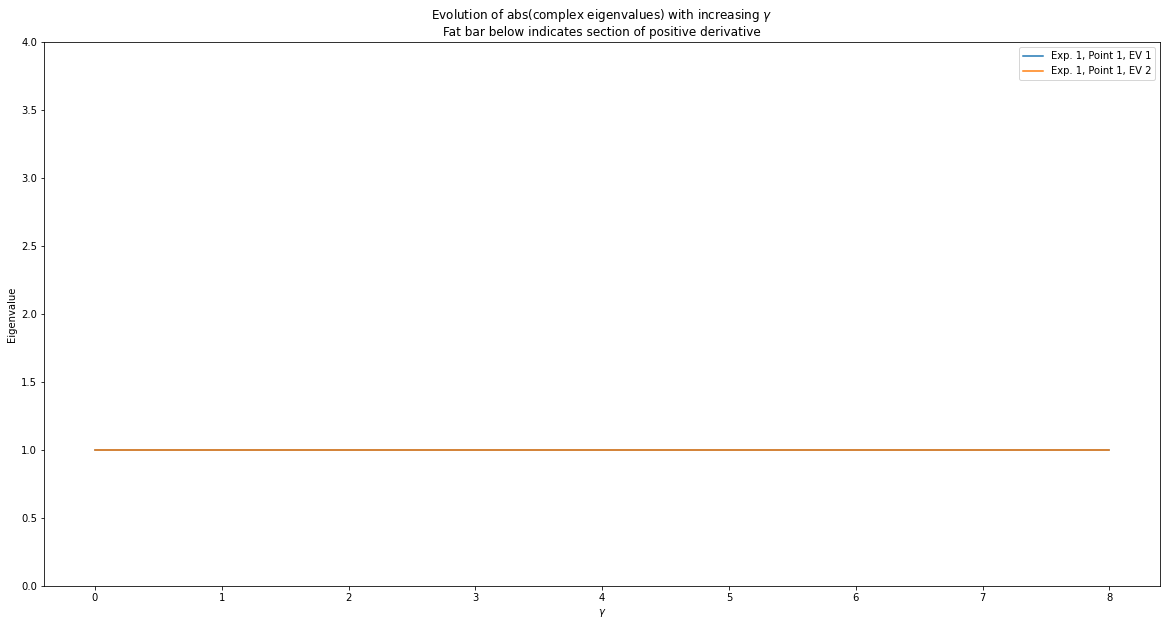

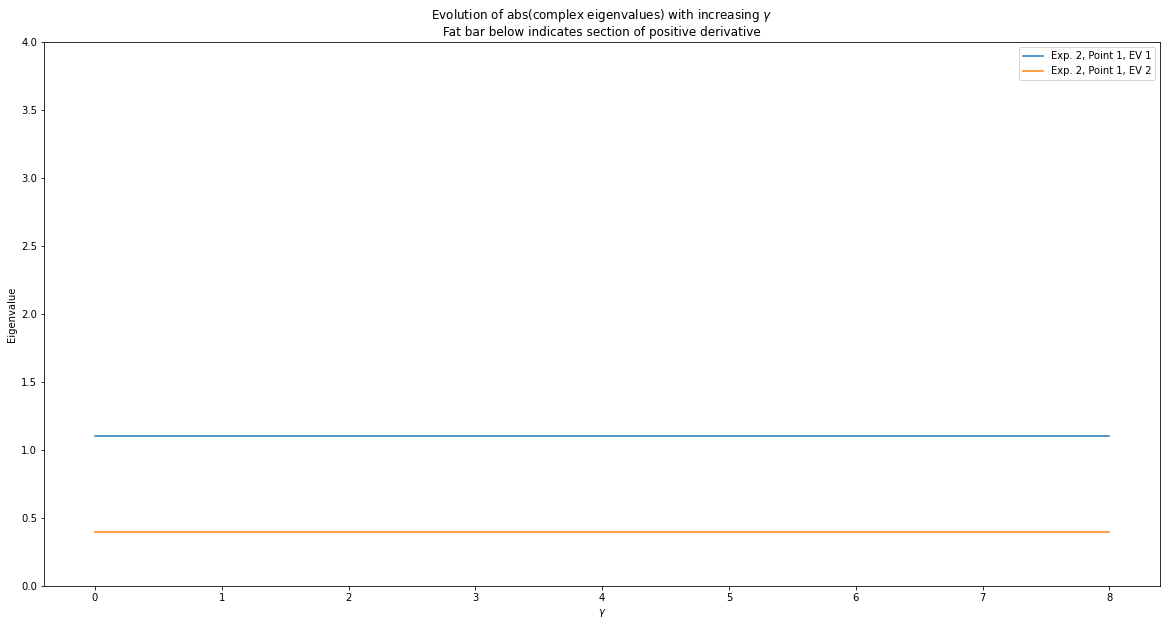

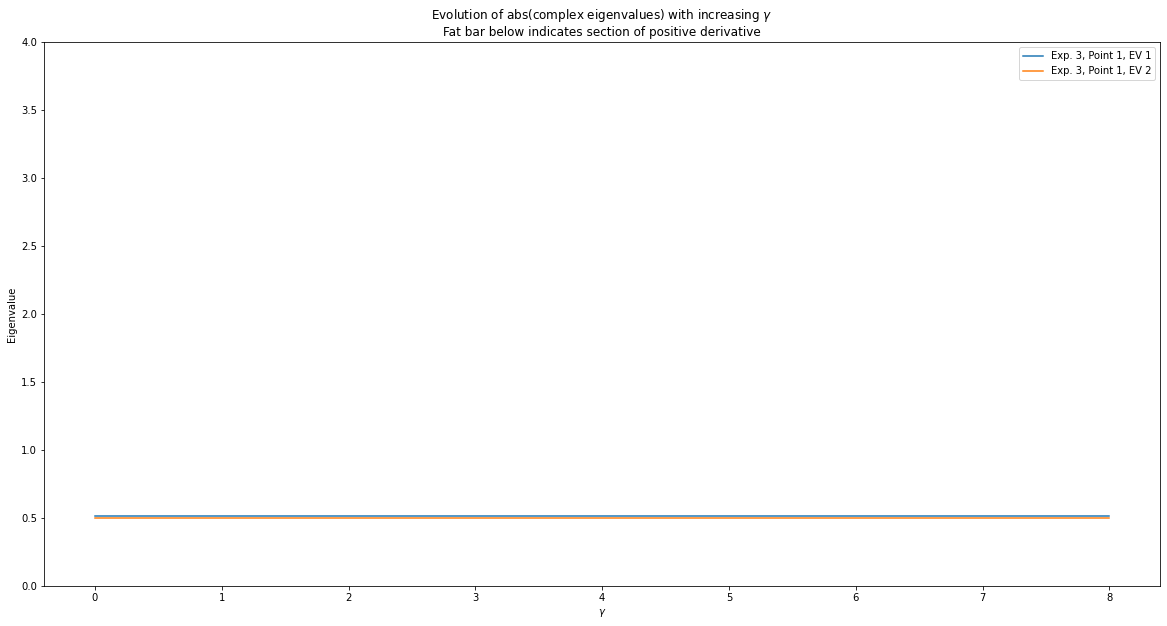

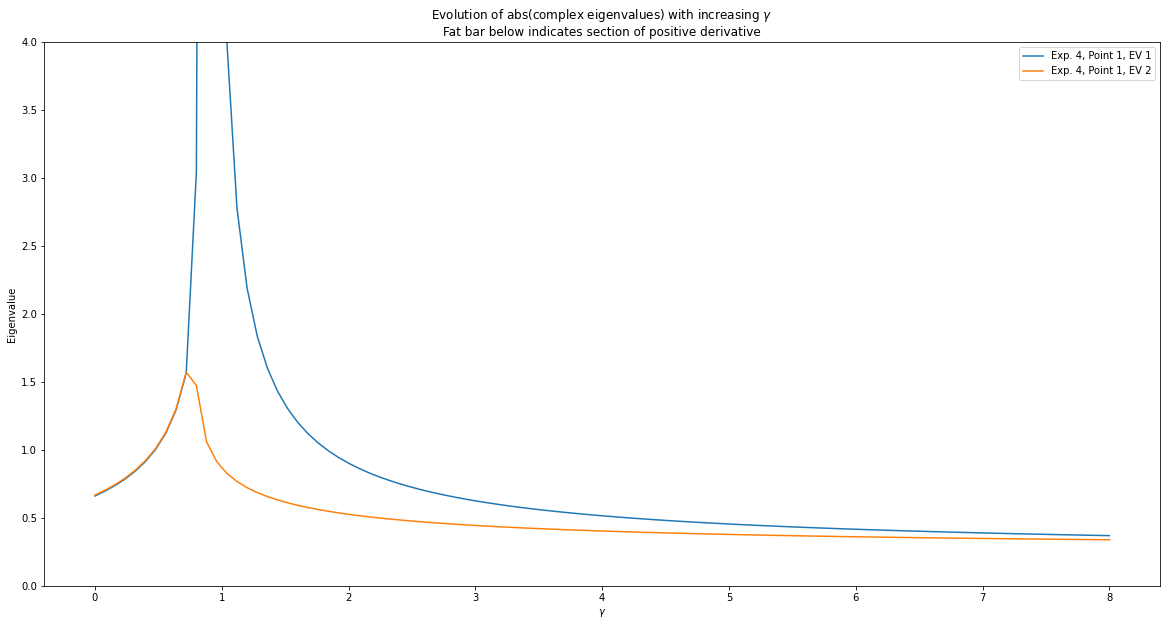

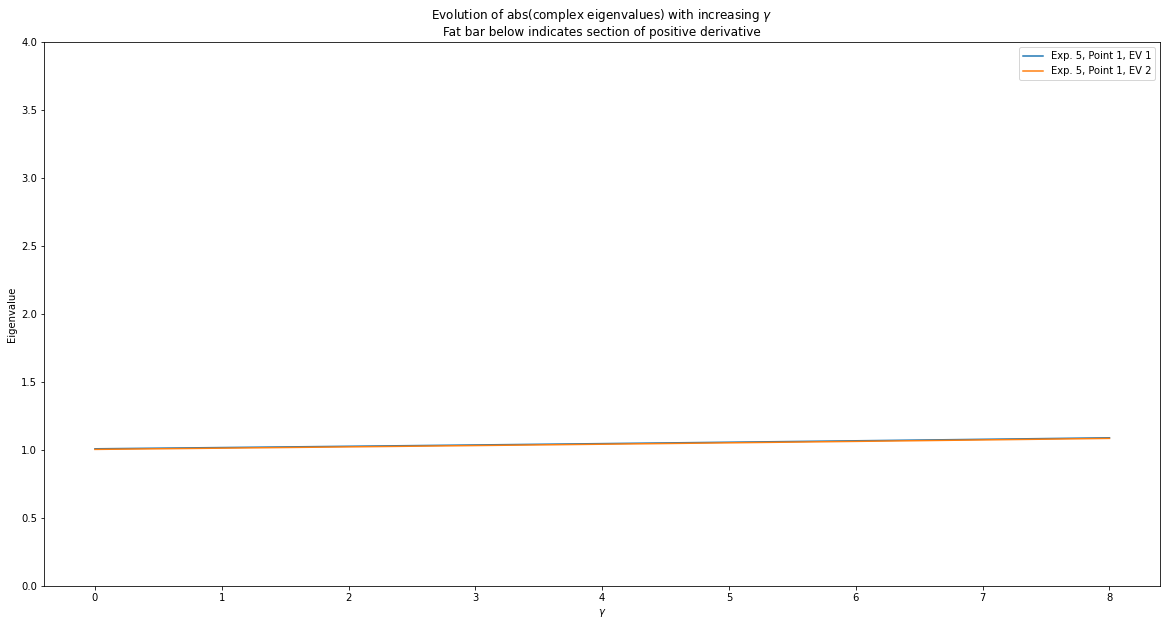

In [90]:
W1 = np.array([[1, 1], [0, 1]])     # shear
W2 = rotation(89)                   # ~90deg rotation
p = np.ones(2)
gammas = np.linspace(0, 8, 101)

mixture = np.linspace(0, 1, 5)
print(mixture)

weights_list = [(1-mix)*W1 + mix*W2 for mix in mixture]

evals, evecs = calc_evals_batch(weights_list, [p], gammas, return_evecs=True)
plot_evals_lineplot(evals, gammas)

In [97]:
x=np.array([.6,-.4])
i = np.ones(2)
for gamma in np.linspace(0,2,11):
    print('\n', gamma)
    y = x + gamma * x.clip(0,None)
    print(y)
    y *= x@i / y@i
    print(y)


 0.0
[ 0.6 -0.4]
-0.16666666666666663
[-0.1         0.06666667]

 0.2
[ 0.72 -0.4 ]
-0.22222222222222215
[-0.16        0.08888889]

 0.4
[ 0.84 -0.4 ]
-0.26190476190476186
[-0.22       0.1047619]

 0.6000000000000001
[ 0.96 -0.4 ]
-0.29166666666666663
[-0.28        0.11666667]

 0.8
[ 1.08 -0.4 ]
-0.31481481481481477
[-0.34        0.12592593]

 1.0
[ 1.2 -0.4]
-0.33333333333333326
[-0.4         0.13333333]

 1.2000000000000002
[ 1.32 -0.4 ]
-0.3484848484848484
[-0.46        0.13939394]

 1.4000000000000001
[ 1.44 -0.4 ]
-0.36111111111111105
[-0.52        0.14444444]

 1.6
[ 1.56 -0.4 ]
-0.3717948717948717
[-0.58        0.14871795]

 1.8
[ 1.68 -0.4 ]
-0.3809523809523809
[-0.64        0.15238095]

 2.0
[ 1.8 -0.4]
-0.3888888888888888
[-0.7         0.15555556]


[[1. 1.]
 [0. 1.]]


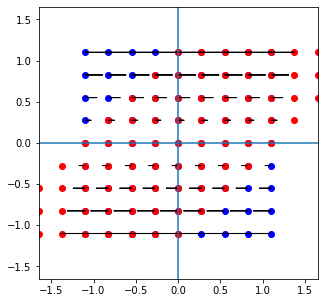

[[0.7543631  0.50003808]
 [0.24996192 0.7543631 ]]


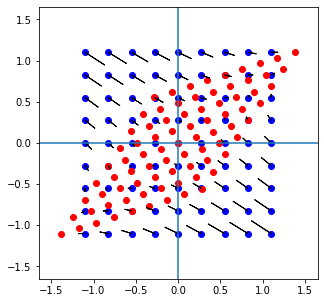

[[5.08726203e-01 7.61524218e-05]
 [4.99923848e-01 5.08726203e-01]]


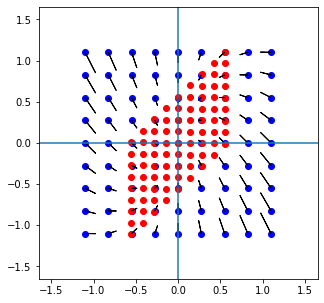

[[ 0.2630893  -0.49988577]
 [ 0.74988577  0.2630893 ]]


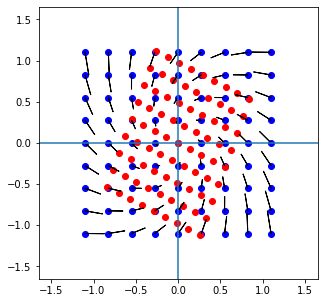

[[ 0.01745241 -0.9998477 ]
 [ 0.9998477   0.01745241]]


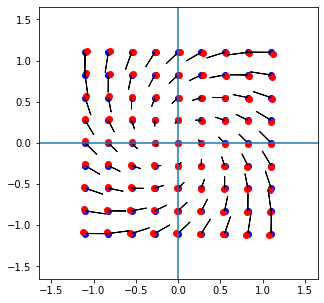

In [91]:
for W in weights_list:
    print(W)
    plot_vector_field(W, figsize=(5,5))
    plt.show()

## Plot rotation vecor field

[[ 1.          0.61237244]
 [-0.61237244  1.        ]]

[1.+0.61237244j 1.-0.61237244j]
[[0.        -0.70710678j 0.        +0.70710678j]
 [0.70710678+0.j         0.70710678-0.j        ]]


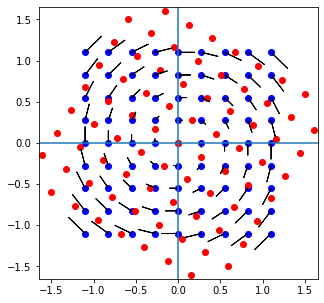

In [174]:
### free variables ###

discriminant = -1.5 # has to be negative for the matrix to have no real eigenvalues.

## seperation into streching and rotation ##

# (a-d)^2 + 4bc = discriminant < 0. <- Criteria for matrix to be a rotation with commplex eigenvectors.
# Easiest: a=d. Then b & c just need to have different signs.
# But if |a-d| is large, then b & c need to be very large (and of different signs). Otherwise the discriminant would be positive.
 
# -> a & d determine the stretching in x & y. If this stretching is not symmetric, we have 'less of an rotation'.
# -> b & c determine the rotation in x & y. The larger their magnitude, the 'stronger a rotation'.


## a & d ##

# a determines the stretching in x-direction.
# d determines the stretching in y-direction.
# if a = -d the result is stretched in both x & y direction by the same degree.
a_minus_d = 0
a = 1

## b & c ##

b_c_distribution = .5 # stretches rotation is x-direction (positive) or y-direction (negative). Only if a != -d.
b_is_positive = False # go counterclockwise?

W = rotation2(discriminant, a_minus_d, a, b_c_distribution, b_is_positive)
(a, b), (c, d) = W
print(W)
print()
evals, evecs = LA.eig(W)
print(evals)
print(evecs)
plot_vector_field(W, figsize=(5,5))

### Varying discriminant
- As $a-d=0$ is constant, the decreasing discribinant increases $|b| = |c|$. This increases the rotational spread, and the Determinant of the rotation.

[[ 1.  0.]
 [-0.  1.]]
Determinant: 1.0


/Users/johannes/Repositories/Masterarbeit/util/util_vector_fields.py:37: RuntimeWarning: invalid value encountered in true_divide
  


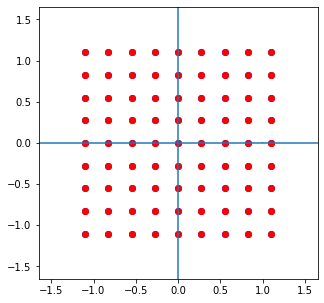

[[ 1.          0.35355339]
 [-0.35355339  1.        ]]
Determinant: 1.125


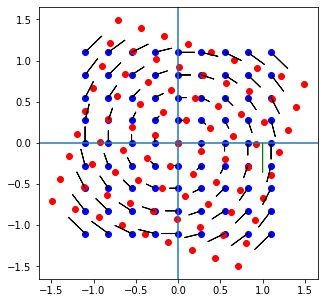

[[ 1.   0.5]
 [-0.5  1. ]]
Determinant: 1.25


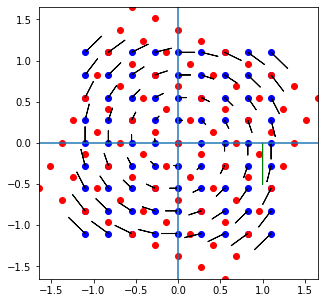

[[ 1.          0.70710678]
 [-0.70710678  1.        ]]
Determinant: 1.5


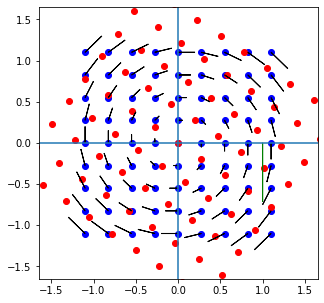

[[ 1.  1.]
 [-1.  1.]]
Determinant: 2.0


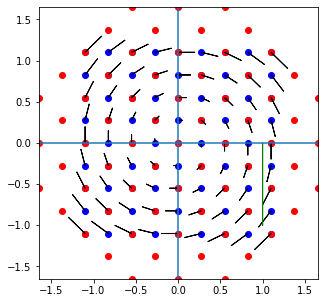

In [184]:
for disc in [0, -.5, -1, -2, -4]:
    W = rotation2(disc, a_minus_d=0, a=1, b_c_distribution=0, b_is_positive=False)
    print(W)
    print("Determinant:", LA.det(W))
    plot_vector_field(W, figsize=(5,5))
    p=np.array([1,0])
    plt.arrow(*p, *(W@p - p), color='green')
    plt.show()


### Varying $|a| = |d|$
- As $a-d=0$ is constant, we vary $|a| = |d|$. This can be interpreted as the "departure angle".

[[ 1.          0.70710678]
 [-0.70710678  1.        ]]
Determinant: 1.5


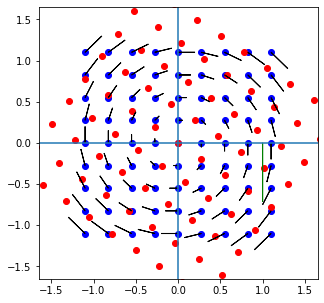

[[ 0.5         0.70710678]
 [-0.70710678  0.5       ]]
Determinant: 0.7500000000000001


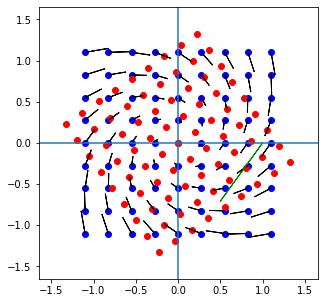

[[ 0.          0.70710678]
 [-0.70710678  0.        ]]
Determinant: 0.5000000000000001


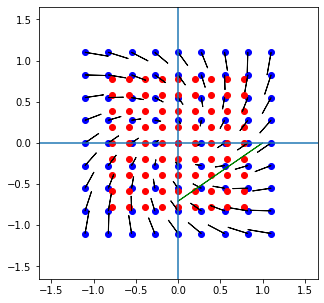

[[-0.5         0.70710678]
 [-0.70710678 -0.5       ]]
Determinant: 0.7500000000000001


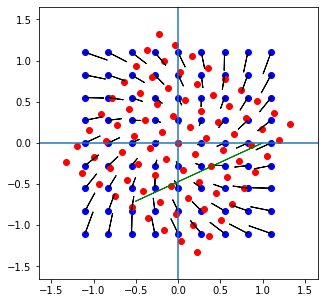

[[-1.          0.70710678]
 [-0.70710678 -1.        ]]
Determinant: 1.5


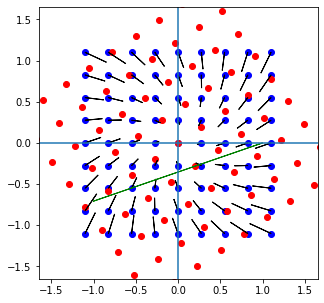

In [188]:
for a in [1, .5, 0, -.5, -1]:
    W = rotation2(discriminant=-2, a_minus_d=0, a=a, b_c_distribution=0, b_is_positive=False)
    print(W)
    print("Determinant:", LA.det(W))
    plot_vector_field(W, figsize=(5,5))
    p=np.array([1,0])
    plt.arrow(*p, *(W@p - p), color='green')
    plt.show()


### Varying $a-d$
- Similar

[[ 1.         0.8660254]
 [-0.8660254  0.       ]]
Determinant: 0.7499999999999999


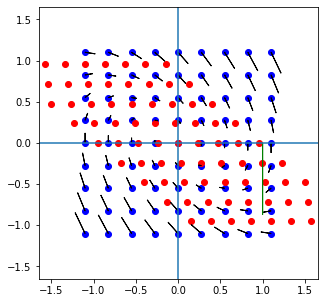

[[ 1.    0.75]
 [-0.75  0.5 ]]
Determinant: 1.0625


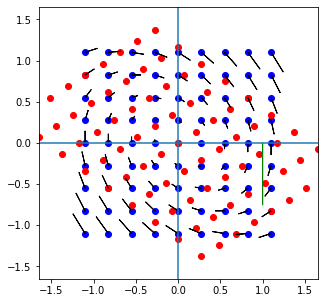

[[ 1.          0.70710678]
 [-0.70710678  1.        ]]
Determinant: 1.5


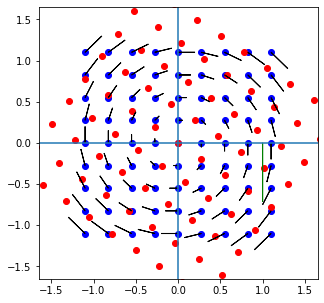

[[ 1.    0.75]
 [-0.75  1.5 ]]
Determinant: 2.0625


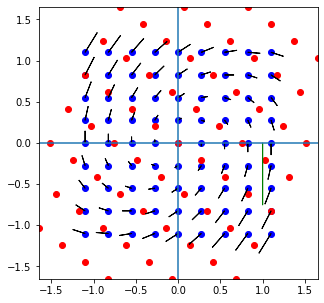

[[ 1.         0.8660254]
 [-0.8660254  2.       ]]
Determinant: 2.75


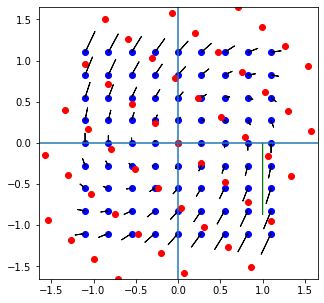

In [190]:
for amd in [1, .5, 0, -.5, -1]:
    W = rotation2(discriminant=-2, a_minus_d=amd, a=1, b_c_distribution=0, b_is_positive=False)
    print(W)
    print("Determinant:", LA.det(W))
    plot_vector_field(W, figsize=(5,5))
    p=np.array([1,0])
    plt.arrow(*p, *(W@p - p), color='green')
    plt.show()


### Varying $b, c$ with $b \cdot c = const.$
- Changes wether there is more 'rotational spread' in x or y direction.

[[ 1.          0.35355339]
 [-1.41421356  1.        ]]
Determinant: 1.5


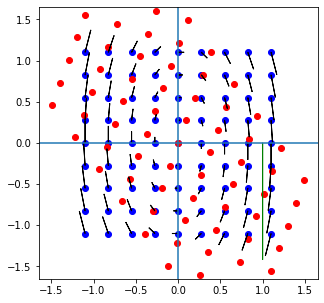

[[ 1.   0.5]
 [-1.   1. ]]
Determinant: 1.5


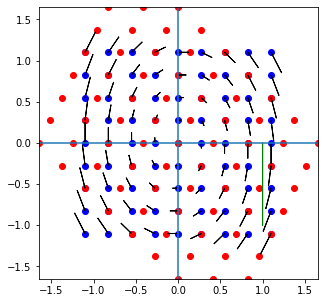

[[ 1.          0.70710678]
 [-0.70710678  1.        ]]
Determinant: 1.5


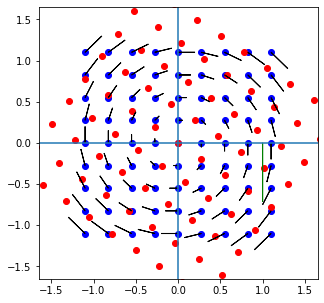

[[ 1.   1. ]
 [-0.5  1. ]]
Determinant: 1.5


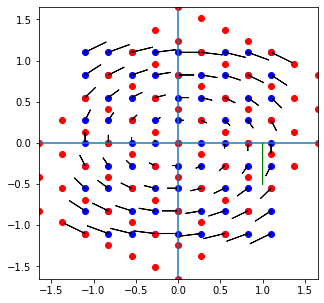

[[ 1.          1.41421356]
 [-0.35355339  1.        ]]
Determinant: 1.5


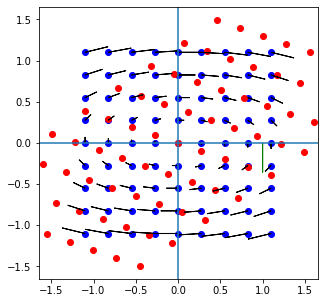

In [191]:
for bcd in [1, .5, 0, -.5, -1]:
    W = rotation2(discriminant=-2, a_minus_d=0, a=1, b_c_distribution=bcd, b_is_positive=False)
    print(W)
    print("Determinant:", LA.det(W))
    plot_vector_field(W, figsize=(5,5))
    p=np.array([1,0])
    plt.arrow(*p, *(W@p - p), color='green')
    plt.show()


## Forward surrogate matrices for different Rotation matrices

In [344]:
weights_list = [rotation2(discriminant=discriminant, a_minus_d=0, a=1, b_c_distribution=0) for discriminant in [0, -.5, -1, -2, -5, -8]]

In [352]:
weights_list = [rotation1(deg) for deg in [-10, -20, -30, -40, -50, -60]]

In [353]:
points_list = [
    [1, 1],
    [np.sqrt(.5), np.sqrt(.5)],
    [0, 1],
    [1, 0],
]
p = points_list[0]

gammas = np.linspace(0, 3, 20)
print(gammas)

computed_evals = calc_evals_batch(weights_list, points_list, gammas=gammas)

[0.         0.15789474 0.31578947 0.47368421 0.63157895 0.78947368
 0.94736842 1.10526316 1.26315789 1.42105263 1.57894737 1.73684211
 1.89473684 2.05263158 2.21052632 2.36842105 2.52631579 2.68421053
 2.84210526 3.        ]
2


In [354]:
# normalize matrices to determinant 1
print('determinants before:', [round(LA.det(W), 2) for W in weights_list])
weights_list = [W * LA.det(W)**-.5 for W in weights_list]
print('determinants after: ', [round(LA.det(W), 2) for W in weights_list])

determinants before: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
determinants after:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


       [[ 0.98  0.17]                [[ 0.94  0.34]                [[ 0.87  0.5 ]                [[ 0.77  0.64]                [[ 0.64  0.77]                [[ 0.5   0.87]                
        [-0.17  0.98]]                [-0.34  0.94]]                [-0.5   0.87]]                [-0.64  0.77]]                [-0.77  0.64]]                [-0.87  0.5 ]]               


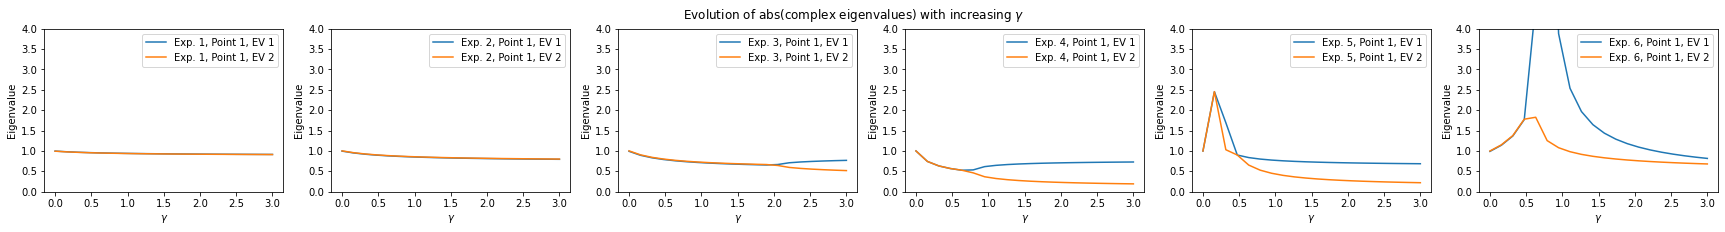

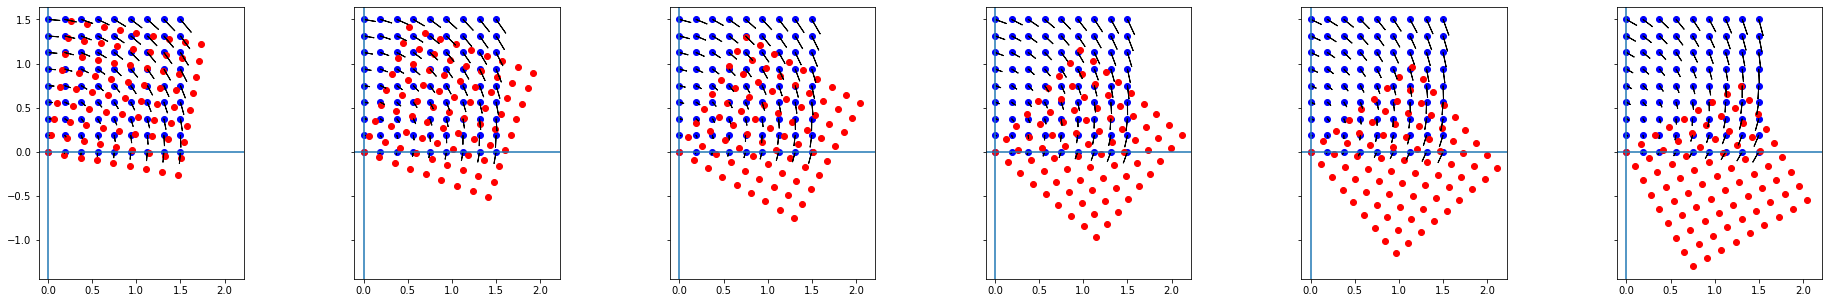

In [373]:
print_weights_list(weights_list)
plot_evals_lineplot(computed_evals[:, :1], gammas, one_plot_per='weight', mark_positive_slope=False)
plot_vector_field_batch(weights_list, lims = np.array([0, 1.5]))

In [379]:
plot_at_gamma = .05
weights_list_prime = [forw_surrogate_matrix(W, p, plot_at_gamma) for W in weights_list]
print(p, gamma); print_weights_list_info(weights_list_prime)

# plot_vector_field_batch(weights_list_prime, lims = np.array([0, 1.5]), point_in_green=p)

[1, 1] 3.0
Weights
       [[ 0.98  0.17]                [[ 0.94  0.34]                [[ 0.87  0.5 ]                [[ 0.77  0.64]                [[ 0.64  0.77]                [[ 0.5   0.87]                
        [-0.16  0.97]]                [-0.32  0.91]]                [-0.45  0.81]]                [-0.49  0.61]]                [-1.04  0.91]]                [-0.93  0.56]]               
Evals
       [0.98+0.17j 0.98-0.17j]       [0.93+0.33j 0.93-0.33j]       [0.84+0.47j 0.84-0.47j]       [0.69+0.56j 0.69-0.56j]       [0.78+0.88j 0.78-0.88j]       [0.53+0.9j 0.53-0.9j]         
Evecs
       [[ 0.72+0.j   0.72-0.j ]      [[ 0.72+0.j    0.72-0.j  ]    [[ 0.73+0.j    0.73-0.j  ]    [[ 0.75+0.j    0.75-0.j  ]    [[0.1 -0.64j 0.1 +0.64j]      [[0.02-0.69j 0.02+0.69j]      
        [-0.02+0.7j -0.02-0.7j]]      [-0.03+0.69j -0.03-0.69j]]    [-0.04+0.69j -0.04-0.69j]]    [-0.09+0.65j -0.09-0.65j]]    [0.76+0.j   0.76-0.j  ]]      [0.72+0.j   0.72-0.j  ]]     


In [380]:
plot_at_gamma = .25
weights_list_prime = [forw_surrogate_matrix(W, p, plot_at_gamma) for W in weights_list]
print(p, gamma); print_weights_list_info(weights_list_prime)

# plot_vector_field_batch(weights_list_prime, lims = np.array([0, 1.5]), point_in_green=p)

[1, 1] 3.0
Weights
       [[ 0.98  0.17]                [[ 0.94  0.34]                [[ 0.87  0.5 ]                [[ 0.77  0.64]                [[ 0.64  0.77]                [[ 0.5   0.87]                
        [-0.13  0.94]]                [-0.25  0.84]]                [-0.31  0.68]]                [-0.25  0.37]]                [ 2.52 -2.65]]                [-1.32  0.95]]               
Evals
       [0.96+0.15j 0.96-0.15j]       [0.89+0.29j 0.89-0.29j]       [0.77+0.39j 0.77-0.39j]       [0.57+0.35j 0.57-0.35j]       [ 1.15 -3.15]                 [0.72+1.04j 0.72-1.04j]       
Evecs
       [[ 0.75+0.j    0.75-0.j  ]    [[ 0.76+0.j    0.76-0.j  ]    [[ 0.78+0.j   0.78-0.j ]      [[ 0.85+0.j    0.85-0.j  ]    [[ 0.83 -0.2 ]                [[0.13-0.62j 0.13+0.62j]      
        [-0.09+0.65j -0.09-0.65j]]    [-0.11+0.64j -0.11-0.64j]]    [-0.15+0.6j -0.15-0.6j]]      [-0.26+0.46j -0.26-0.46j]]    [ 0.55  0.98]]                [0.78+0.j   0.78-0.j  ]]     


In [381]:
plot_at_gamma = .5
weights_list_prime = [forw_surrogate_matrix(W, p, plot_at_gamma) for W in weights_list]
print(p, gamma); print_weights_list_info(weights_list_prime)

# plot_vector_field_batch(weights_list_prime, lims = np.array([0, 1.5]), point_in_green=p)

[1, 1] 3.0
Weights
       [[ 0.98  0.17]                [[ 0.94  0.34]                [[ 0.87  0.5 ]                [[ 0.77  0.64]                [[ 0.64  0.77]                [[ 0.5   0.87]                
        [-0.11  0.92]]                [-0.19  0.79]]                [-0.23  0.6 ]]                [-0.16  0.28]]                [ 0.48 -0.6 ]]                [-2.73  2.37]]               
Evals
       [0.95+0.13j 0.95-0.13j]       [0.86+0.24j 0.86-0.24j]       [0.73+0.31j 0.73-0.31j]       [0.52+0.2j 0.52-0.2j]         [ 0.89 -0.85]                 [1.43+1.22j 1.43-1.22j]       
Evecs
       [[ 0.79+0.j   0.79-0.j ]      [[ 0.8 +0.j    0.8 -0.j  ]    [[ 0.83+0.j    0.83-0.j  ]    [[ 0.9 +0.j    0.9 -0.j  ]    [[ 0.95 -0.46]                [[0.3 -0.39j 0.3 +0.39j]      
        [-0.15+0.6j -0.15-0.6j]]      [-0.18+0.57j -0.18-0.57j]]    [-0.22+0.51j -0.22-0.51j]]    [-0.34+0.28j -0.34-0.28j]]    [ 0.31  0.89]]                [0.87+0.j   0.87-0.j  ]]     


In [382]:
plot_at_gamma = 1
weights_list_prime = [forw_surrogate_matrix(W, p, plot_at_gamma) for W in weights_list]
print(p, gamma); print_weights_list_info(weights_list_prime)

# plot_vector_field_batch(weights_list_prime, lims = np.array([0, 1.5]), point_in_green=p)

[1, 1] 3.0
Weights
       [[ 0.98  0.17]                [[ 0.94  0.34]                [[ 0.87  0.5 ]                [[ 0.77  0.64]                [[ 0.64  0.77]                [[ 0.5   0.87]                
        [-0.08  0.89]]                [-0.13  0.73]]                [-0.15  0.51]]                [-0.09  0.21]]                [ 0.18 -0.3 ]]                [ 2.37 -2.73]]               
Evals
       [0.94+0.11j 0.94-0.11j]       [0.84+0.19j 0.84-0.19j]       [0.69+0.21j 0.69-0.21j]       [0.63 0.35]                   [ 0.77 -0.43]                 [ 1.04 -3.27]                 
Evecs
       [[ 0.83+0.j    0.83-0.j  ]    [[ 0.85+0.j    0.85-0.j  ]    [[ 0.88+0.j    0.88-0.j  ]    [[ 0.98 -0.84]                [[ 0.99 -0.58]                [[ 0.85 -0.22]                
        [-0.23+0.51j -0.23-0.51j]]    [-0.26+0.46j -0.26-0.46j]]    [-0.31+0.37j -0.31-0.37j]]    [-0.21  0.54]]                [ 0.17  0.81]]                [ 0.53  0.97]]               


### Problem: Matrix rows with a negative sum.
- Turning gamma up, would eventually make the sum positive.
- At the same time we counter this by multiplying all the rows entries with the coefficient $c_j$.
- At the crossing point the Eval diverges!
- After the crossing point, the rows entries **all change sign**!


In [384]:
print_weights_list_info([forw_surrogate_matrix(rotation1(-60), np.ones(2), gamma) for gamma in [.5, 1]])

Weights
       [[ 0.5   0.87]                [[ 0.5   0.87]                
        [-2.73  2.37]]                [ 2.37 -2.73]]               
Evals
       [1.43+1.22j 1.43-1.22j]       [ 1.04 -3.27]                 
Evecs
       [[0.3 -0.39j 0.3 +0.39j]      [[ 0.85 -0.22]                
        [0.87+0.j   0.87-0.j  ]]      [ 0.53  0.97]]               


## The four steps of EV evolution - The problems of recover_activations

In [450]:
W = np.array([[ 0.5,  1. ],
       [-1. ,  0.5]])

[0.         0.15789474 0.31578947 0.47368421 0.63157895 0.78947368
 0.94736842 1.10526316 1.26315789 1.42105263 1.57894737 1.73684211
 1.89473684 2.05263158 2.21052632 2.36842105 2.52631579 2.68421053
 2.84210526 3.        ]


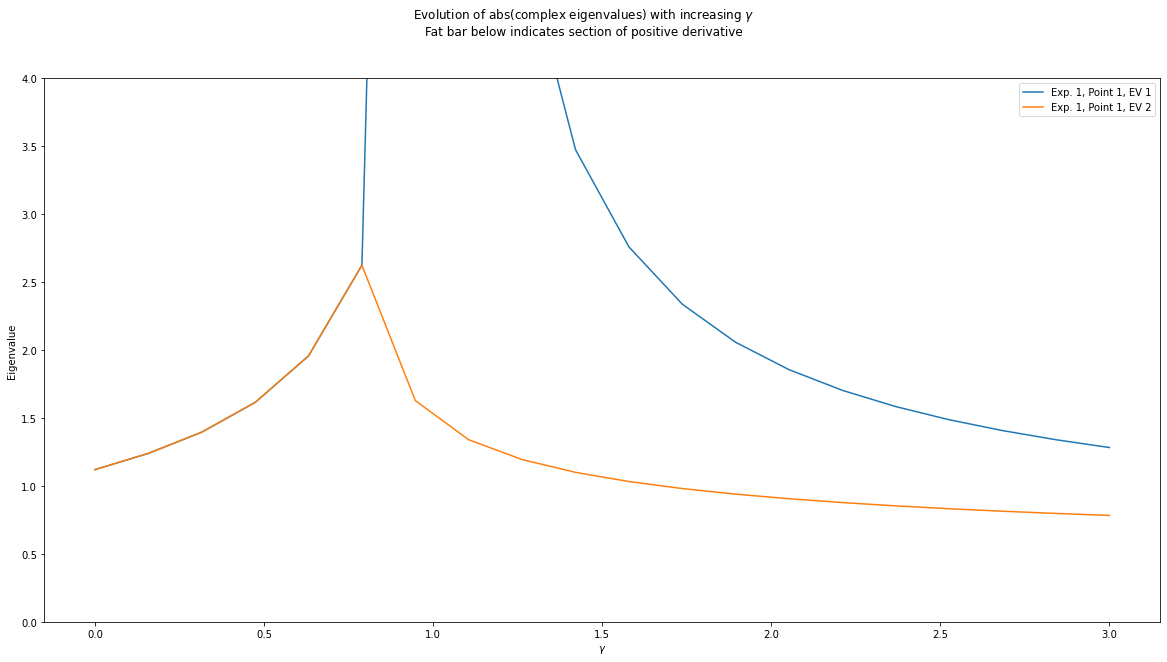

In [451]:
gammas = np.linspace(0, 3, 20)
print(gammas)

p = np.ones(2)

computed_evals = calc_evals_batch([W], [p], gammas=gammas)
plot_evals_lineplot(computed_evals, gammas)

#### 1. Significant gamma applied, but the matrix is still a rotation with two complex EVs

In [435]:
forw = forw_surrogate_matrix(W, p, 0.82)
print(forw)

evals, evecs = LA.eig(forw)
print(evals)
print(evecs)

[[ 0.5         1.        ]
 [-5.55555556  5.05555556]]
[2.77777778+0.60603956j 2.77777778-0.60603956j]
[[0.37743559-0.10042283j 0.37743559+0.10042283j]
 [0.92057462+0.j         0.92057462-0.j        ]]


#### 2. Gamma crosses threshold, now both EVs are real and not conjugates of each other anymore

In [437]:
forw = forw_surrogate_matrix(W, p, 0.83)
print(forw)

evals, evecs = LA.eig(forw)
print(evals)
print(evecs)

[[ 0.5         1.        ]
 [-5.88235294  5.38235294]]
[2.66370644 3.2186465 ]
[[-0.41953065 -0.34521697]
 [-0.90774117 -0.93852291]]


#### 3. Gamma is so high that the sum of the (unnormalized) second row of the matrix goes to 0. Thus, in recover_activations, the rows entries get divided by a very small $c_j$ and diverge.
- By recover_activations, I refer to the process of matching the surrogate models next-layer-activations to the original forward model. 

In [448]:
forw = forw_surrogate_matrix(W, p, .99)
print(forw)

evals, evecs = LA.eig(forw)
print(evals)
print(evecs)

[[   0.5    1. ]
 [-100.    99.5]]
[ 1.52062294 98.47937706]
[[-0.69985344 -0.0102057 ]
 [-0.71428647 -0.99994792]]


#### 4. Another threshold: The sum of unnormalized second row entire crosses 0. The rows signs flip all at the same time. This is a major divergence from the original models behaviour...
- ... even though the recover_activations is motivated by recovering the original models activations.

In [ ]:
forw = forw_surrogate_matrix(W, p, 1.01)
print(forw)

evals, evecs = LA.eig(forw)
print(evals)
print(evecs)

[[   0.5    1. ]
 [ 100.  -100.5]]
[   1.48057886 -101.48057886]
[[ 0.71400619 -0.00980532]
 [ 0.70013938  0.99995193]]


### Visualization of turn real, and flip

- Right before the first threshold (gamma = 0.825), the point cloud get rotated a bit, but mostly gets stretched out in y-direction.
- After, the EVs turn real.
- Now there is strongy-axis stretching, without rotation.
- At the second threshold, the y-axis stretching flips its sign. 
- --> This is very undesirable

gamma = 0.0
[[ 0.5  1. ]
 [-1.   0.5]]

[0.5+1.j 0.5-1.j]
[[0.70710678+0.j         0.70710678-0.j        ]
 [0.        +0.70710678j 0.        -0.70710678j]]


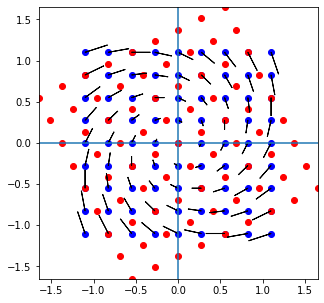

gamma = 0.15789473684210525
[[ 0.5     1.    ]
 [-1.1875  0.6875]]

[0.59375+1.08568455j 0.59375-1.08568455j]
[[0.05816751-0.67361666j 0.05816751+0.67361666j]
 [0.7367884 +0.j         0.7367884 -0.j        ]]


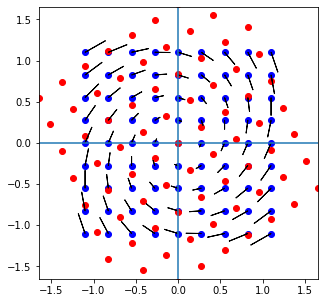

gamma = 0.3157894736842105
[[ 0.5         1.        ]
 [-1.46153846  0.96153846]]

[0.73076923+1.18671143j 0.73076923-1.18671143j]
[[0.12166607-0.62565755j 0.12166607+0.62565755j]
 [0.77055175+0.j         0.77055175-0.j        ]]


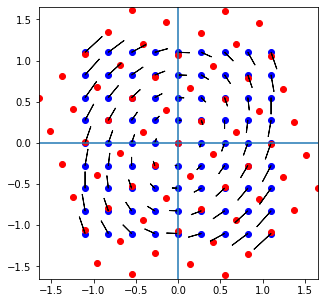

gamma = 0.47368421052631576
[[ 0.5  1. ]
 [-1.9  1.4]]

[0.95+1.30288142j 0.95-1.30288142j]
[[0.19170645-0.55504615j 0.19170645+0.55504615j]
 [0.80942721+0.j         0.80942721-0.j        ]]


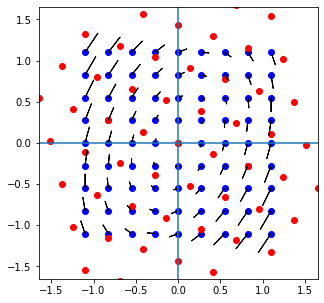

gamma = 0.631578947368421
[[ 0.5         1.        ]
 [-2.71428571  2.21428571]]

[1.35714286+1.40697969j 1.35714286-1.40697969j]
[[0.26995276-0.44312106j 0.26995276+0.44312106j]
 [0.85485041+0.j         0.85485041-0.j        ]]


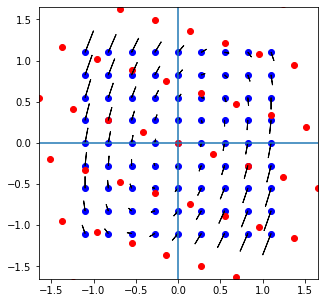

gamma = 0.7894736842105263
[[ 0.5   1.  ]
 [-4.75  4.25]]

[2.375+1.1110243j 2.375-1.1110243j]
[[0.35877365-0.21259j 0.35877365+0.21259j]
 [0.90889326+0.j      0.90889326-0.j     ]]


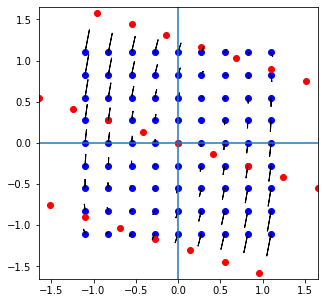

gamma = 0.9473684210526315
[[  0.5   1. ]
 [-19.   18.5]]

[ 1.62599213 17.37400787]
[[-0.66403664 -0.05915895]
 [-0.74770003 -0.99824858]]


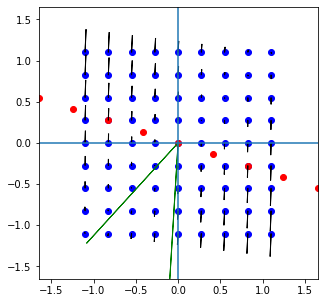

gamma = 1.1052631578947367
[[  0.5   1. ]
 [  9.5 -10. ]]

[  1.33789783 -10.83789783]
[[ 0.76649784 -0.0878587 ]
 [ 0.64224688  0.99613295]]


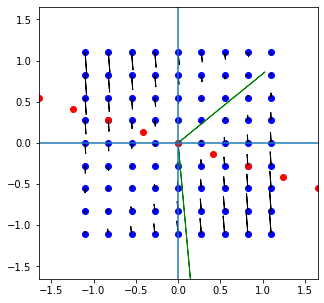

gamma = 1.263157894736842
[[ 0.5  1. ]
 [ 3.8 -4.3]]

[ 1.19192497 -4.99192497]
[[ 0.82233946 -0.17914003]
 [ 0.5689972   0.98382359]]


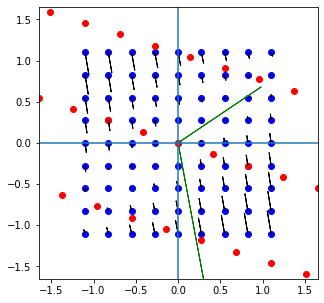

gamma = 1.4210526315789473
[[ 0.5    1.   ]
 [ 2.375 -2.875]]

[ 1.09781316 -3.47281316]
[[ 0.85831991 -0.24409677]
 [ 0.51311494  0.96975088]]


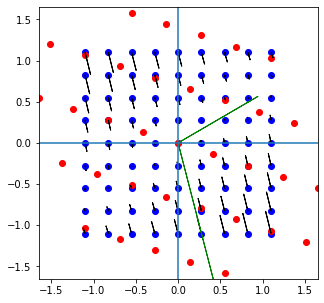

gamma = 1.5789473684210527
[[ 0.5         1.        ]
 [ 1.72727273 -2.22727273]]

[ 1.03024242 -2.75751515]
[[ 0.88348426 -0.29346588]
 [ 0.46846084  0.95596955]]


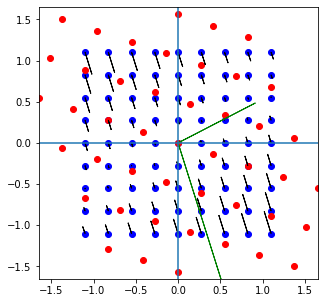

gamma = 1.7368421052631577
[[ 0.5         1.        ]
 [ 1.35714286 -1.85714286]]

[ 0.97858682 -2.33572968]
[[ 0.90201975 -0.33256999]
 [ 0.43169477  0.94307858]]


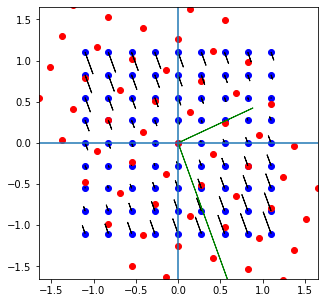

gamma = 1.894736842105263
[[ 0.5         1.        ]
 [ 1.11764706 -1.61764706]]

[ 0.93742322 -2.05507028]
[[ 0.91618317 -0.36445937]
 [ 0.40075979  0.93121929]]


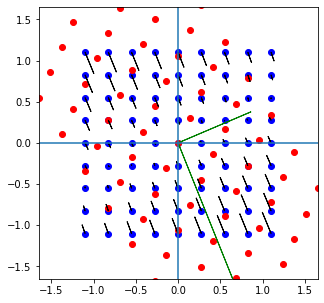

gamma = 2.052631578947368
[[ 0.5   1.  ]
 [ 0.95 -1.45]]

[ 0.90363157 -1.85363157]
[[ 0.92731091 -0.39104345]
 [ 0.37429196  0.92037222]]


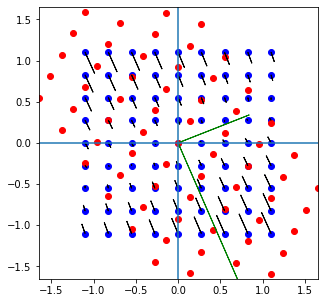

gamma = 2.2105263157894735
[[ 0.5         1.        ]
 [ 0.82608696 -1.32608696]]

[ 0.87526369 -1.70135064]
[[ 0.93624799 -0.4135925 ]
 [ 0.35133987  0.91046211]]


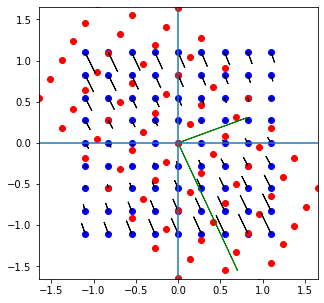

gamma = 2.3684210526315788
[[ 0.5         1.        ]
 [ 0.73076923 -1.23076923]]

[ 0.85102805 -1.58179728]
[[ 0.94355551 -0.43299052]
 [ 0.33121445  0.90139848]]


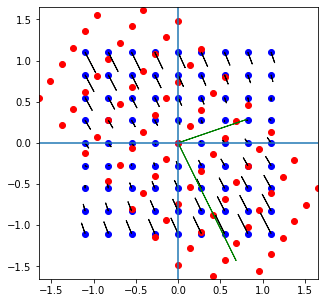

gamma = 2.526315789473684
[[ 0.5         1.        ]
 [ 0.65517241 -1.15517241]]

[ 0.8300283  -1.48520071]
[[ 0.94962065 -0.44987474]
 [ 0.31340169  0.89309166]]


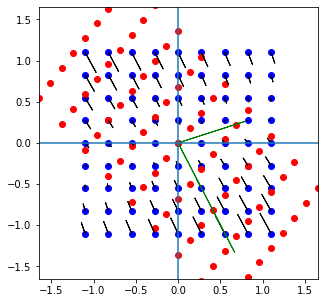

gamma = 2.6842105263157894
[[ 0.5      1.     ]
 [ 0.59375 -1.09375]]

[ 0.81161937 -1.40536937]
[[ 0.95471903 -0.46471771]
 [ 0.29750894  0.88545889]]


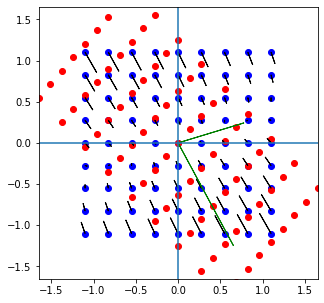

gamma = 2.8421052631578947
[[ 0.5         1.        ]
 [ 0.54285714 -1.04285714]]

[ 0.79532313 -1.33818027]
[[ 0.95905195 -0.47787813]
 [ 0.28323022  0.87842615]]


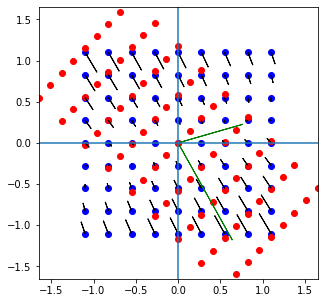

gamma = 3.0
[[ 0.5  1. ]
 [ 0.5 -1. ]]

[ 0.78077641 -1.28077641]
[[ 0.96276969 -0.48963374]
 [ 0.27032301  0.87192821]]


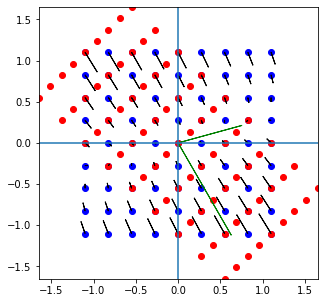

In [455]:
W = np.array([[ 0.5,  1. ],
       [-1. ,  0.5]])
       
for gamma in gammas:
    Wp = forw_surrogate_matrix(W, p, gamma)
    print("gamma =", gamma)
    print(Wp)
    print()
    
    evals, evecs = LA.eig(Wp)
    print(evals)
    print(evecs)
    plot_vector_field(Wp, figsize=(5,5))

    if not np.any(np.iscomplex(evecs)):
        plt.arrow(0, 0, *(evecs[:,0]*evals[0]), color='green')
        plt.arrow(0, 0, *(evecs[:,1]*evals[1]), color='green')
    plt.show()
    

## Without recover_activations coefficients

In [401]:
points_list

[[1, 1], [0.7071067811865476, 0.7071067811865476], [0, 1], [1, 0]]

       [[ 0.98  0.17]               [[ 0.94  0.34]               [[ 0.87  0.5 ]               [[ 0.77  0.64]               [[ 0.64  0.77]               [[ 0.5   0.87]               
        [-0.17  0.98]]               [-0.34  0.94]]               [-0.5   0.87]]               [-0.64  0.77]]               [-0.77  0.64]]               [-0.87  0.5 ]]              


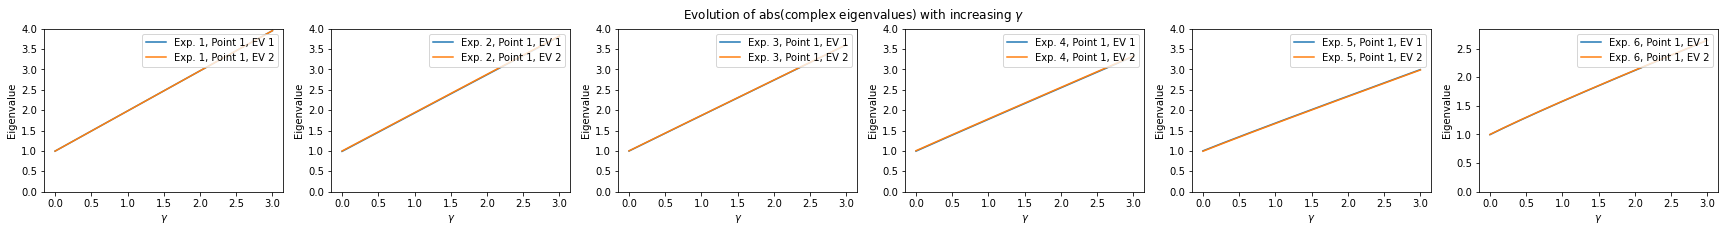

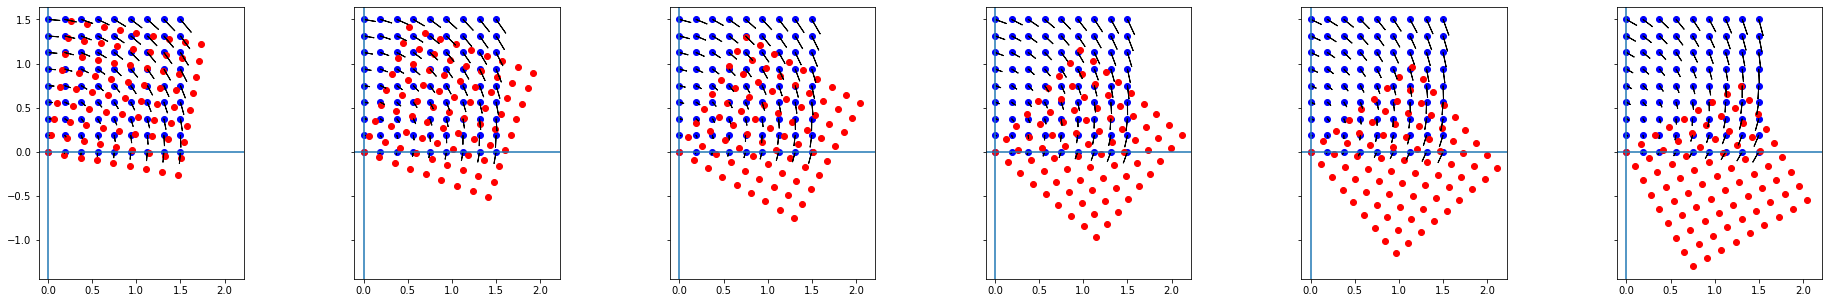

In [415]:
p_i = 2

print_weights_list(weights_list)
plot_evals_lineplot(computed_evals[:, p_i:p_i+1], gammas, one_plot_per='weight', mark_positive_slope=False, percentile_to_plot=100)
plot_vector_field_batch(weights_list, lims = np.array([0, 1.5]))

[1, 1] 3.0
Weights
       [[ 1.03  0.18]               [[ 0.99  0.36]               [[ 0.91  0.53]               [[ 0.8   0.67]               [[ 0.67  0.8 ]               [[ 0.53  0.91]               
        [-0.17  1.03]]               [-0.34  0.99]]               [-0.5   0.91]]               [-0.64  0.8 ]]               [-0.77  0.67]]               [-0.87  0.52]]              
Evals
       [1.03+0.18j 1.03-0.18j]      [0.99+0.35j 0.99-0.35j]      [0.91+0.51j 0.91-0.51j]      [0.8+0.66j 0.8-0.66j]        [0.67+0.78j 0.67-0.78j]      [0.52+0.89j 0.52-0.89j]      
Evecs
       [[0.72+0.j  0.72-0.j ]       [[ 0.72+0.j   0.72-0.j ]     [[ 0.72+0.j   0.72-0.j ]     [[ 0.72+0.j   0.72-0.j ]     [[ 0.72+0.j   0.72-0.j ]     [[ 0.72+0.j   0.72-0.j ]     
        [0.  +0.7j 0.  -0.7j]]       [-0.  +0.7j -0.  -0.7j]]     [-0.  +0.7j -0.  -0.7j]]     [-0.  +0.7j -0.  -0.7j]]     [-0.  +0.7j -0.  -0.7j]]     [-0.  +0.7j -0.  -0.7j]]    


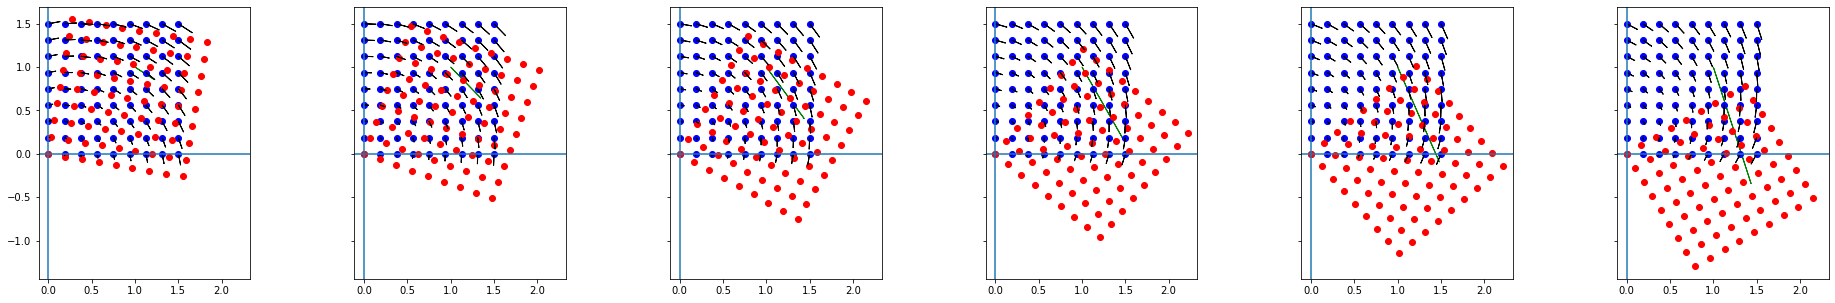

In [411]:
plot_at_gamma = .05
weights_list_prime = [forw_surrogate_matrix(W, points_list[p_i], plot_at_gamma, recover_activations=False) for W in weights_list]
print(p, gamma); print_weights_list_info(weights_list_prime)

plot_vector_field_batch(weights_list_prime, lims = np.array([0, 1.5]), point_in_green=p)

[1, 1] 3.0
Weights
       [[ 1.23  0.22]               [[ 1.17  0.43]               [[ 1.08  0.63]               [[ 0.96  0.8 ]               [[ 0.8   0.96]               [[ 0.63  1.08]               
        [-0.17  1.23]]               [-0.34  1.17]]               [-0.5   1.08]]               [-0.64  0.96]]               [-0.77  0.8 ]]               [-0.87  0.62]]              
Evals
       [1.23+0.19j 1.23-0.19j]      [1.17+0.38j 1.17-0.38j]      [1.08+0.56j 1.08-0.56j]      [0.96+0.72j 0.96-0.72j]      [0.8+0.86j 0.8-0.86j]        [0.62+0.97j 0.62-0.97j]      
Evecs
       [[0.75+0.j   0.75-0.j  ]     [[ 0.75+0.j    0.75-0.j  ]   [[ 0.75+0.j    0.75-0.j  ]   [[ 0.75+0.j    0.75-0.j  ]   [[ 0.75+0.j    0.75-0.j  ]   [[ 0.75+0.j    0.75-0.j  ]   
        [0.  +0.67j 0.  -0.67j]]     [-0.  +0.67j -0.  -0.67j]]   [-0.  +0.67j -0.  -0.67j]]   [-0.  +0.67j -0.  -0.67j]]   [-0.  +0.67j -0.  -0.67j]]   [-0.  +0.67j -0.  -0.67j]]  


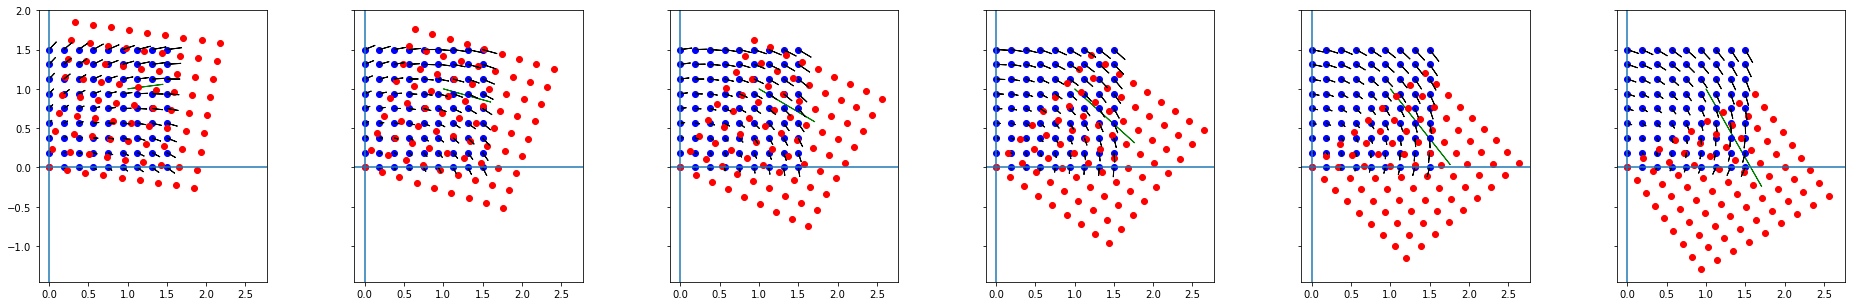

In [412]:
plot_at_gamma = .25
weights_list_prime = [forw_surrogate_matrix(W, points_list[p_i], plot_at_gamma, recover_activations=False) for W in weights_list]
print(p, gamma); print_weights_list_info(weights_list_prime)

plot_vector_field_batch(weights_list_prime, lims = np.array([0, 1.5]), point_in_green=p)

[1, 1] 3.0
Weights
       [[ 1.48  0.26]               [[ 1.41  0.51]               [[ 1.3   0.75]               [[ 1.15  0.96]               [[ 0.96  1.15]               [[ 0.75  1.3 ]               
        [-0.17  1.48]]               [-0.34  1.41]]               [-0.5   1.3 ]]               [-0.64  1.15]]               [-0.77  0.96]]               [-0.87  0.75]]              
Evals
       [1.48+0.21j 1.48-0.21j]      [1.41+0.42j 1.41-0.42j]      [1.3+0.61j 1.3-0.61j]        [1.15+0.79j 1.15-0.79j]      [0.96+0.94j 0.96-0.94j]      [0.75+1.06j 0.75-1.06j]      
Evecs
       [[0.77+0.j   0.77-0.j  ]     [[ 0.77+0.j    0.77-0.j  ]   [[0.77+0.j   0.77-0.j  ]     [[ 0.77+0.j    0.77-0.j  ]   [[ 0.77+0.j    0.77-0.j  ]   [[ 0.77+0.j    0.77-0.j  ]   
        [0.  +0.63j 0.  -0.63j]]     [-0.  +0.63j -0.  -0.63j]]   [0.  +0.63j 0.  -0.63j]]     [-0.  +0.63j -0.  -0.63j]]   [-0.  +0.63j -0.  -0.63j]]   [-0.  +0.63j -0.  -0.63j]]  


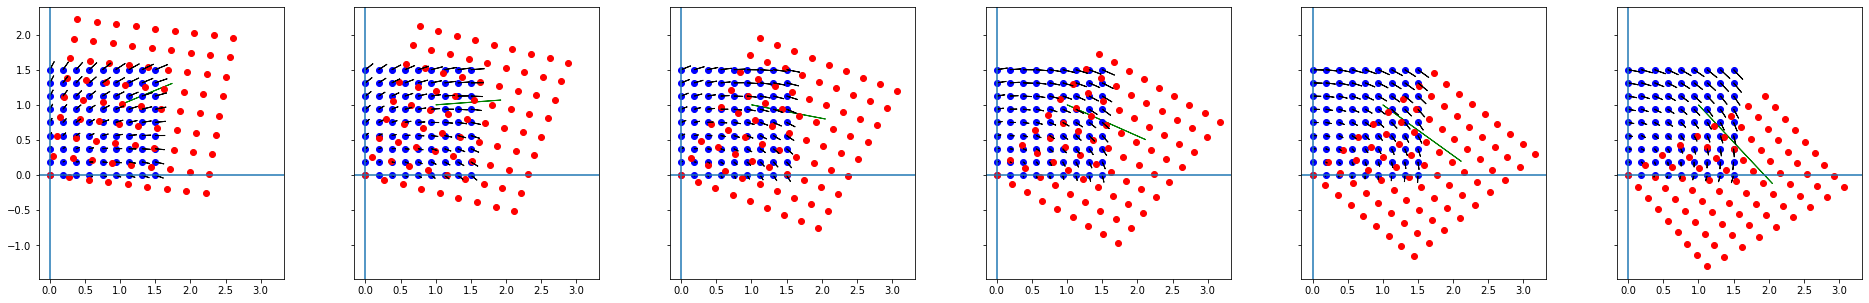

In [413]:
plot_at_gamma = .5
weights_list_prime = [forw_surrogate_matrix(W, points_list[p_i], plot_at_gamma, recover_activations=False) for W in weights_list]
print(p, gamma); print_weights_list_info(weights_list_prime)

plot_vector_field_batch(weights_list_prime, lims = np.array([0, 1.5]), point_in_green=p)

## Looking at backward matrices.

#### Check functionality of back matrix
--> Looks good.

In [595]:
gamma_to_plot = 0
weights_list = [rotation1(deg) for deg in [-10, -20, -30, -40, -50, -60]]

points_list = np.array([
    [1, 1],
    [np.sqrt(.5), np.sqrt(.5)],
    [0, 1],
    [1, 0],
    [.2, .8]
])
p = points_list[0]

print("weights:")
print_weights_list(weights_list)
print("forw surrogate (no recovery):")
print_weights_list([forw_surrogate_matrix(W, None, gamma_to_plot, recover_activations=False) for W in weights_list])
print("back:")
print_weights_list([back_matrix(W, points_list[1], gamma_to_plot) for W in weights_list])

weights:
       [[ 0.98  0.17]               [[ 0.94  0.34]               [[ 0.87  0.5 ]               [[ 0.77  0.64]               [[ 0.64  0.77]               [[ 0.5   0.87]               
        [-0.17  0.98]]               [-0.34  0.94]]               [-0.5   0.87]]               [-0.64  0.77]]               [-0.77  0.64]]               [-0.87  0.5 ]]              
forw surrogate (no recovery):
       [[ 0.98  0.17]               [[ 0.94  0.34]               [[ 0.87  0.5 ]               [[ 0.77  0.64]               [[ 0.64  0.77]               [[ 0.5   0.87]               
        [-0.17  0.98]]               [-0.34  0.94]]               [-0.5   0.87]]               [-0.64  0.77]]               [-0.77  0.64]]               [-0.87  0.5 ]]              
back:
       [[ 0.85 -0.21]               [[ 0.73 -0.57]               [[ 0.63 -1.37]               [[ 0.54 -5.22]               [[ 0.46  6.22]               [[ 0.37  2.37]               
        [ 0.15  1.21]]               [ 0.27  

### For different rotation strengths, plot their vector field, and the Evals with increasing gamma

point = [0.3190391  0.24937038]
       -15                          -30                          -45                          -60                          -75                          -90                          
       [[ 0.97  0.26]               [[ 0.87  0.5 ]               [[ 0.71  0.71]               [[ 0.5   0.87]               [[ 0.26  0.97]               [[ 0.  1.]                   
        [-0.26  0.97]]               [-0.5   0.87]]               [-0.71  0.71]]               [-0.87  0.5 ]]               [-0.97  0.26]]               [-1.  0.]]                  


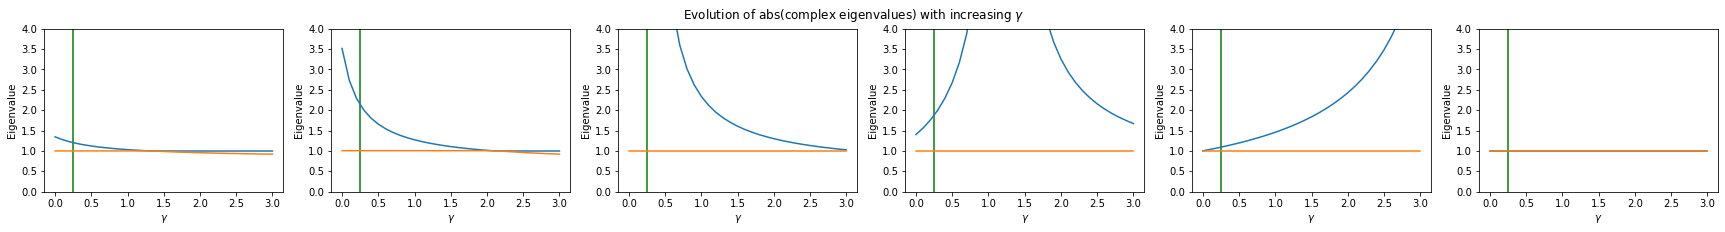

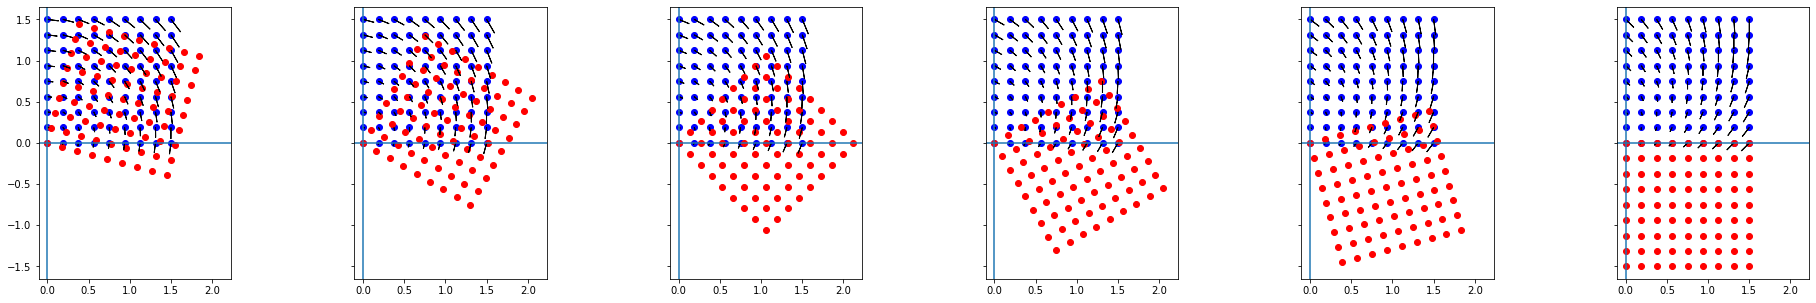

In [11]:
gamma_to_plot = 0.
gammas = np.linspace(0,3,31)

p_i = 4
print("point =", points_list[p_i])

degrees = np.array([-15, -30, -45, -60, -75, -90])
print_weights_list(degrees)

weights_list = [rotation1(deg) for deg in degrees]
print_weights_list(weights_list)

computed_evals = calc_evals_batch(weights_list, points_list[p_i:p_i+1], gammas, mode="back")
plot_evals_lineplot(computed_evals, gammas, one_plot_per='weight', mark_positive_slope=False, percentile_to_plot=None)

plot_vector_field_batch(weights_list, lims = np.array([0, 1.5]))

### Bombard matrices with lots of random datapoints

In [12]:
n = 100
rs = RandomState(1)
points_list = np.abs(rs.normal(0,1, size=(n,2)))
points_list[:4]

array([[1.62434536, 0.61175641],
       [0.52817175, 1.07296862],
       [0.86540763, 2.3015387 ],
       [1.74481176, 0.7612069 ]])

Degree to rotate by:
       -15                          -30                          -45                          -60                          -75                          -90                          
Weight matrices that do the rotation:
       [[ 0.97  0.26]               [[ 0.87  0.5 ]               [[ 0.71  0.71]               [[ 0.5   0.87]               [[ 0.26  0.97]               [[ 0.  1.]                   
        [-0.26  0.97]]               [-0.5   0.87]]               [-0.71  0.71]]               [-0.87  0.5 ]]               [-0.97  0.26]]               [-1.  0.]]                  


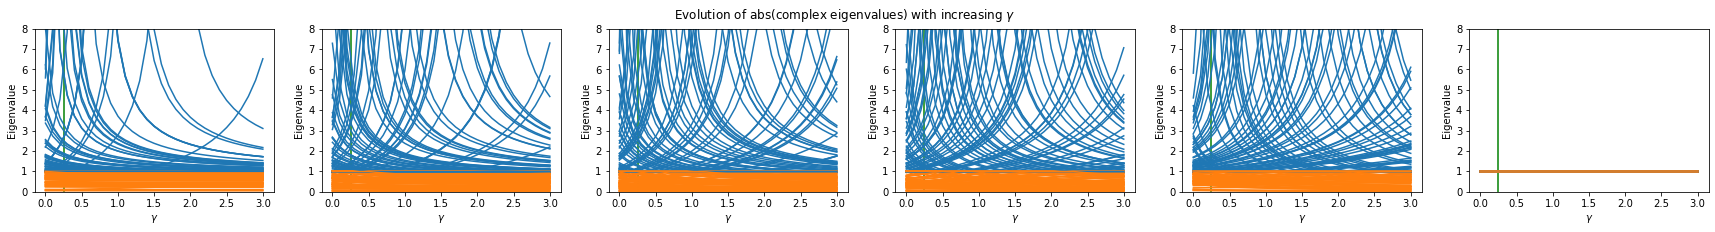

In [13]:
print("Degree to rotate by:")
degrees = np.array([-15, -30, -45, -60, -75, -90])
print_weights_list(degrees)

print("Weight matrices that do the rotation:")
weights_list = [rotation1(deg) for deg in degrees]
print_weights_list(weights_list)

computed_evals = calc_evals_batch(weights_list, points_list, gammas, mode="back")
plot_evals_lineplot(computed_evals, gammas, one_plot_per='weight', mark_positive_slope=False, percentile_to_plot=None, ylim=8)

### Find location of maxima

#### Finding
- Invariant to scale of points or matrices

In [52]:
degs = np.linspace(0, 340, 18)
weights_list = [rotation1(deg) for deg in degs]
weights_lbls = [f"rot{round(deg)}" for deg in degs]

In [53]:
n = 200
rs = RandomState(1)
points_list = np.abs(rs.normal(0, 1, size=(n,2)))
computed_evals1 = calc_evals_batch(weights_list, points_list, gammas, mode="back")

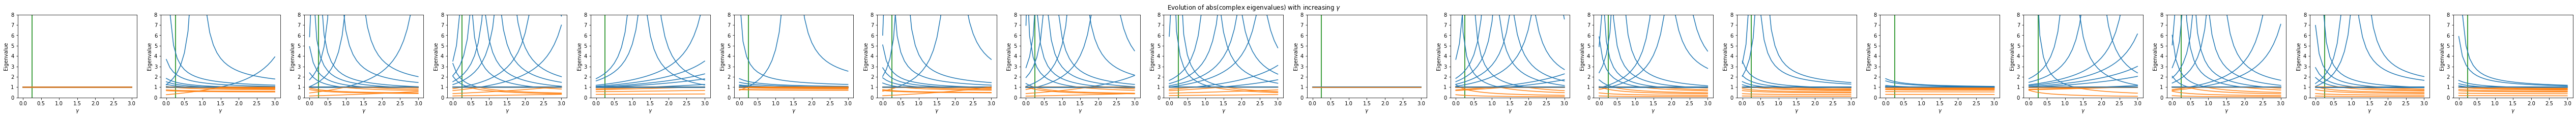

In [54]:
plot_evals_lineplot(computed_evals1[:, :10], gammas, one_plot_per='weight', mark_positive_slope=False, percentile_to_plot=None, ylim=8)

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:431: RuntimeWarning: divide by zero encountered in true_divide
  if lower_bound or upper_bound: peaks_for_one_weight = peaks_for_one_weight.clip(lower_bound, upper_bound)


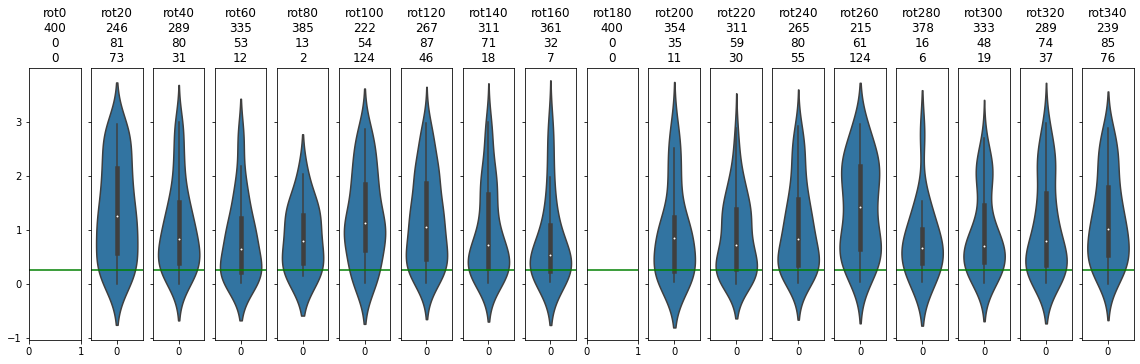

In [55]:
peaks = sign_flip_distribution_plot(weights_list, points_list, weights_lbls)

### Row wise gammas

In [2]:
degs = np.linspace(0, 160, 9)
weights_list = [rotation1(deg) for deg in degs]
weights_lbls = [f"rot{round(deg)}" for deg in degs]

In [3]:
n = 10
rs = RandomState(1)
points_list = np.abs(rs.normal(0, 1, size=(n,2)))

In [4]:
gammas = np.linspace(0, 1, 101)[:-1] # -> [0, 1)
gammas[:5], gammas[-5:]

(array([0.  , 0.01, 0.02, 0.03, 0.04]), array([0.95, 0.96, 0.97, 0.98, 0.99]))

#### Old: Global gamma

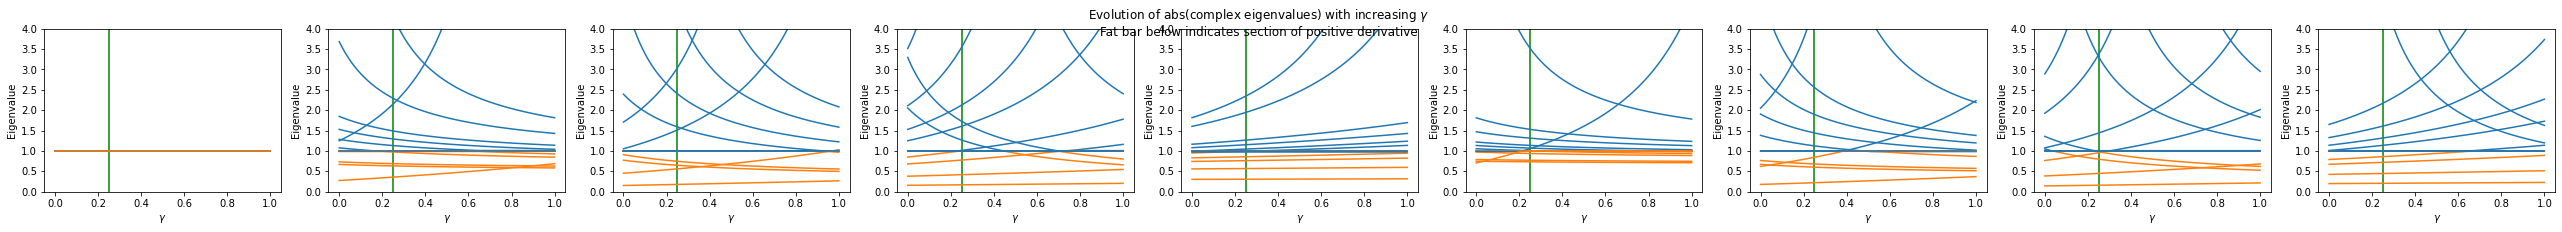

In [134]:
computed_evals = calc_evals_batch(weights_list, points_list, gammas, mode='back')
plot_evals_lineplot(computed_evals, gammas)

#### Gammas per row & datapoint. (Slight parameter changes below)

In [ ]:
computed_evals = calc_evals_batch(weights_list, points_list, gammas, mode='back', smart_gamma_func=smart_gamma_max_before_sign_flip)

#### Clip lower to 0, Upper to 100000

       rot0                rot20               rot40               rot60               rot80               rot100              rot120              rot140              rot160              

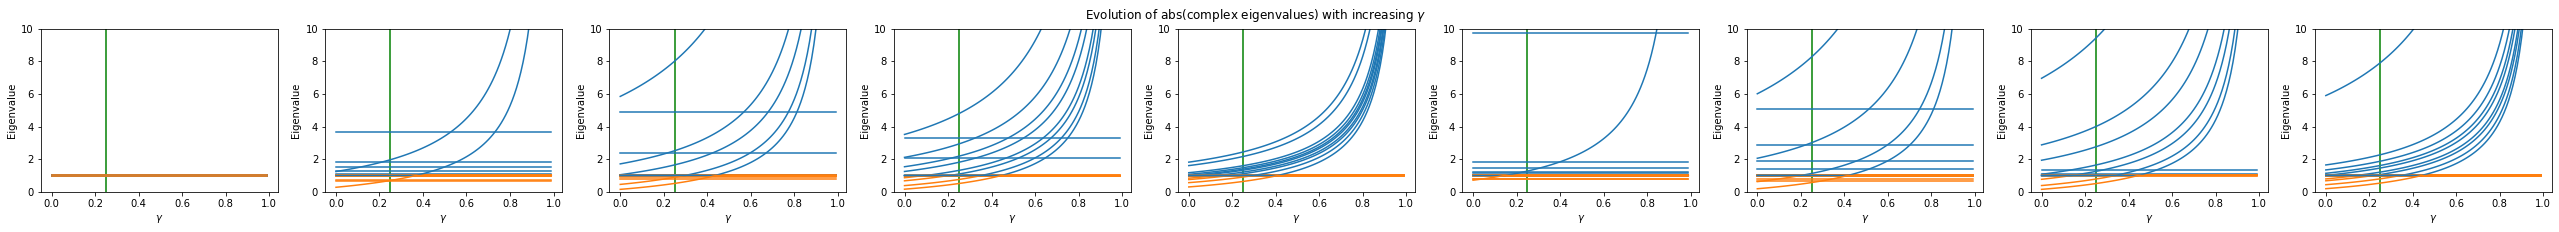

In [14]:
print(' '*7, end='')
for item in weights_lbls:
    print(f"{item:20s}", end="")
plot_evals_lineplot(computed_evals, gammas, ylim=10)

#### Clip lower to 0

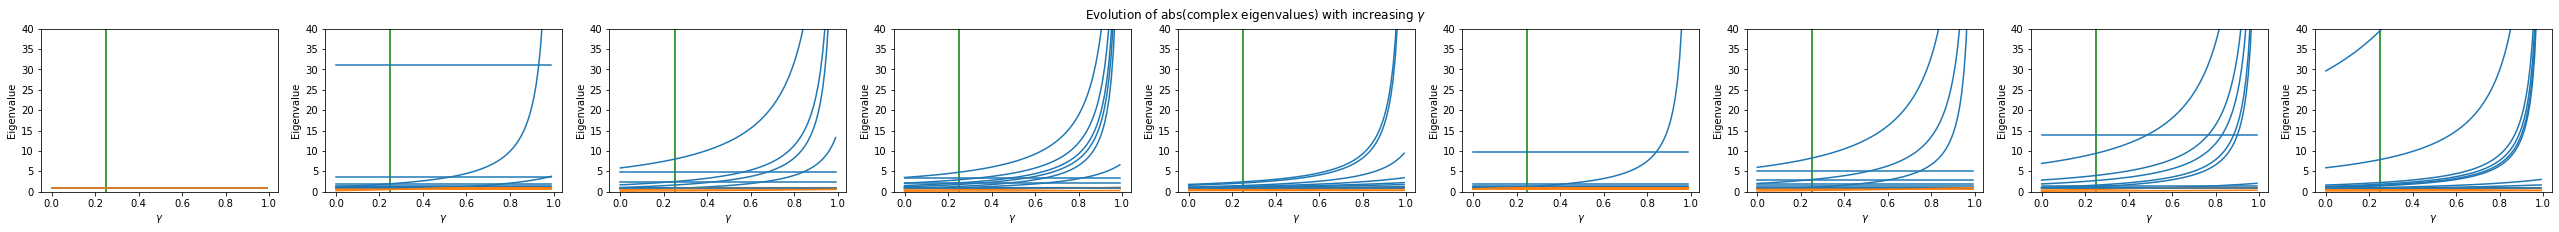

In [ ]:
plot_evals_lineplot(computed_evals, gammas, ylim=40)

#### Clip all negative to 0.25

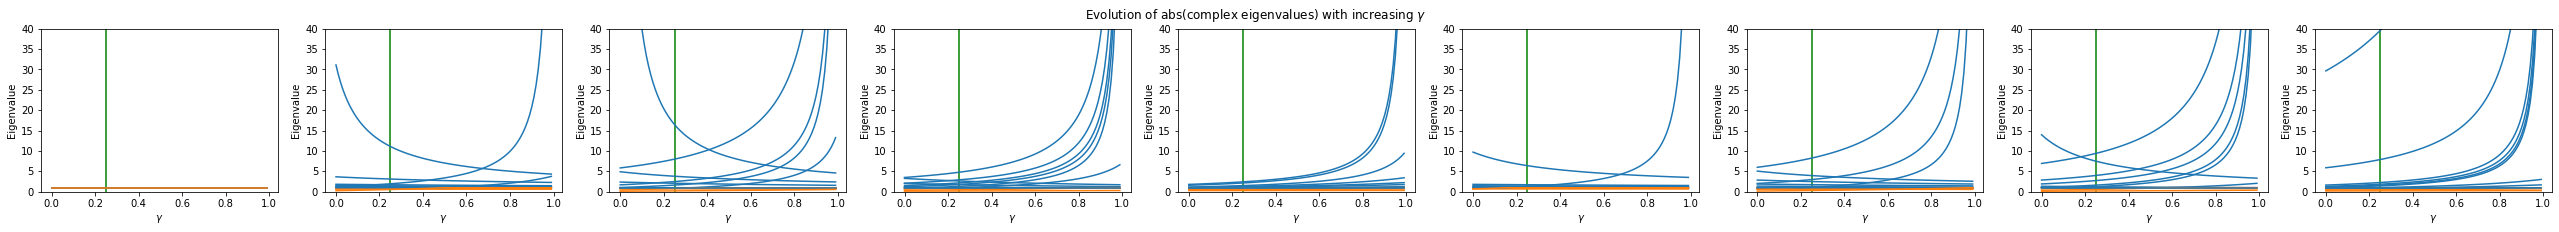

In [294]:
plot_evals_lineplot(computed_evals, gammas, ylim=40)

### Row-wise gamma: Details & Vector fields

#### Findings
- Only some rotation matrices are affected by the gamma rule at all
- This also depends on where in the first quadrant the datapoint lies.

In [358]:
more_datapoints = True
more_datapoints_random = False

points_list = [p]
rng = RandomState(2)
if more_datapoints: 
    if more_datapoints_random:
        points_list += [np.abs(rng.random(2)) for _ in range(9)]
    else:
        saf = 0.05
        points_list += [[np.cos(deg), np.sin(deg)] for deg in np.linspace(0 + saf, np.pi/2 - saf, 9)]

points_list = np.array(points_list)

(-0.1, 1.1)

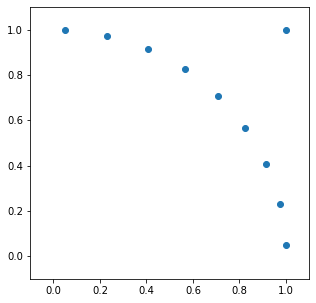

In [359]:
plt.figure(figsize=(5,5))
plt.scatter(*points_list.T)
plt.xlim((-.1,1.1))
plt.ylim((-.1,1.1))

['rot0', 'rot-23', 'rot-46', 'rot-68', 'rot-91']
       [[1. 0.]                     [[ 0.92  0.39]               [[ 0.7   0.71]               [[ 0.37  0.93]               [[-0.02  1.  ]               
        [0. 1.]]                     [-0.39  0.92]]               [-0.71  0.7 ]]               [-0.93  0.37]]               [-1.   -0.02]]              


/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:437: RuntimeWarning: divide by zero encountered in true_divide
  peaks_for_one_weight = - sum_at_neg_weight_entries / sum_at_pos_weight_entries - 1


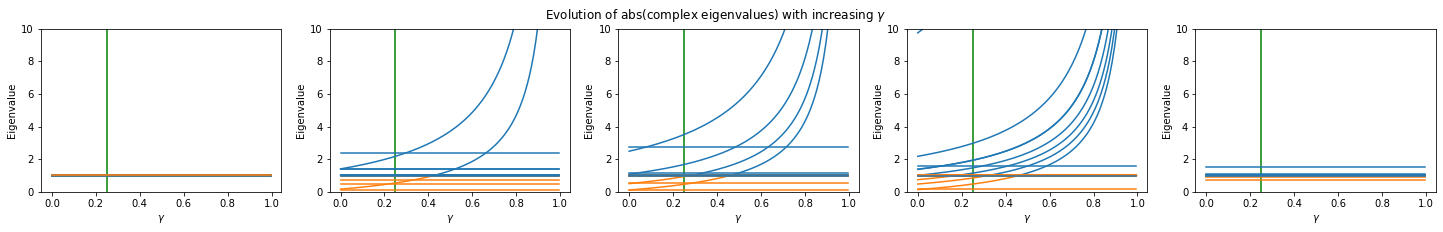

point = [1. 1.]


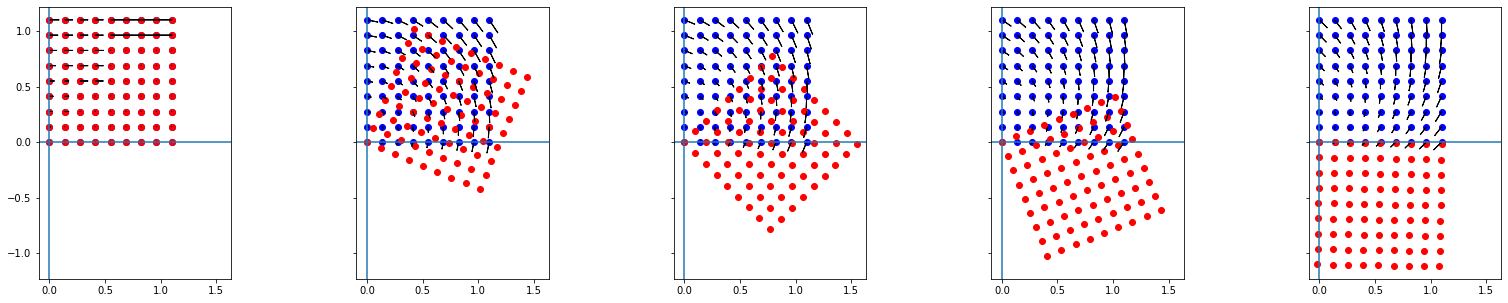

In [361]:
degs = np.linspace(0, -91, 5)
weights_list = [rotation1(deg) for deg in degs]
weights_lbls = [f"rot{round(deg)}" for deg in degs]

p = np.ones(2)

print(weights_lbls)
print_weights_list(weights_list)
plot_evals_lineplot(calc_evals_batch(weights_list, points_list, mode='back', smart_gamma_func=smart_gamma_max_before_sign_flip), ylim=10)
plt.show()

print('point =', p)
plot_vector_field_batch(weights_list, lims = np.array([0, 1.1]))

=== 0.1 ===
       [[1. 0.]                     [[-1.63  0.63]               [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 2.63  0.37]]               [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:437: RuntimeWarning: divide by zero encountered in true_divide
  peaks_for_one_weight = - sum_at_neg_weight_entries / sum_at_pos_weight_entries - 1


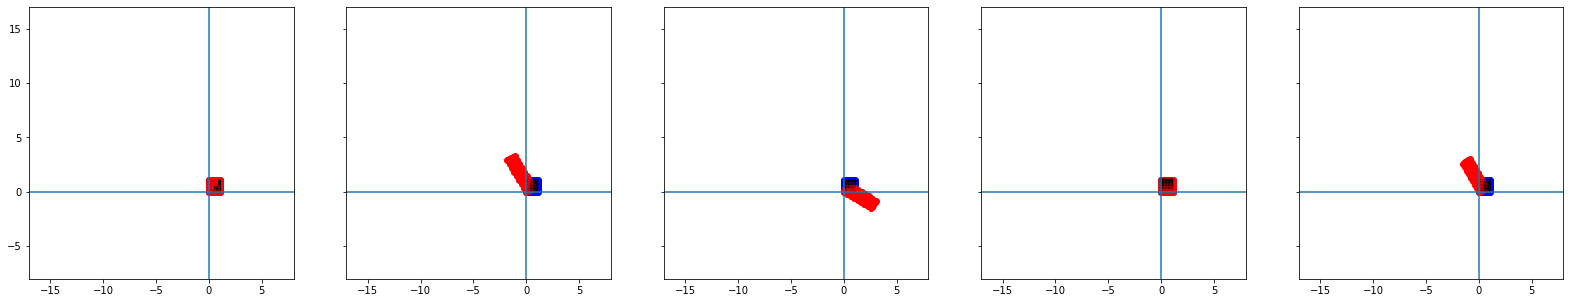

=== 0.3 ===
       [[1. 0.]                     [[-2.38  0.63]               [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 3.38  0.37]]               [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


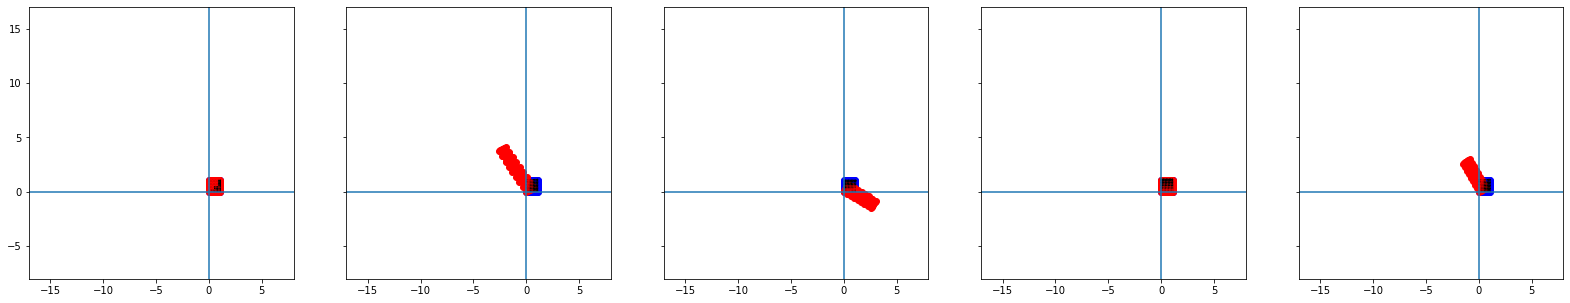

=== 0.5 ===
       [[1. 0.]                     [[-3.73  0.63]               [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 4.73  0.37]]               [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


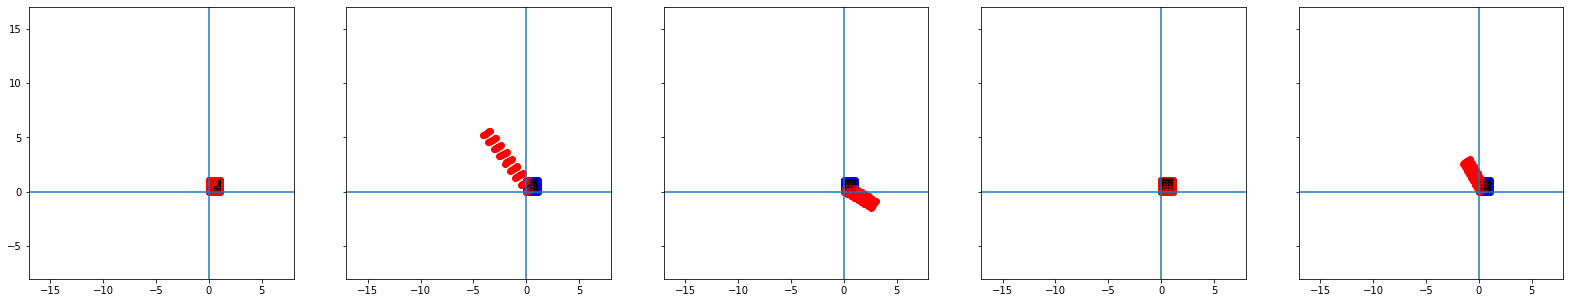

=== 0.7 ===
       [[1. 0.]                     [[-6.89  0.63]               [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 7.89  0.37]]               [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


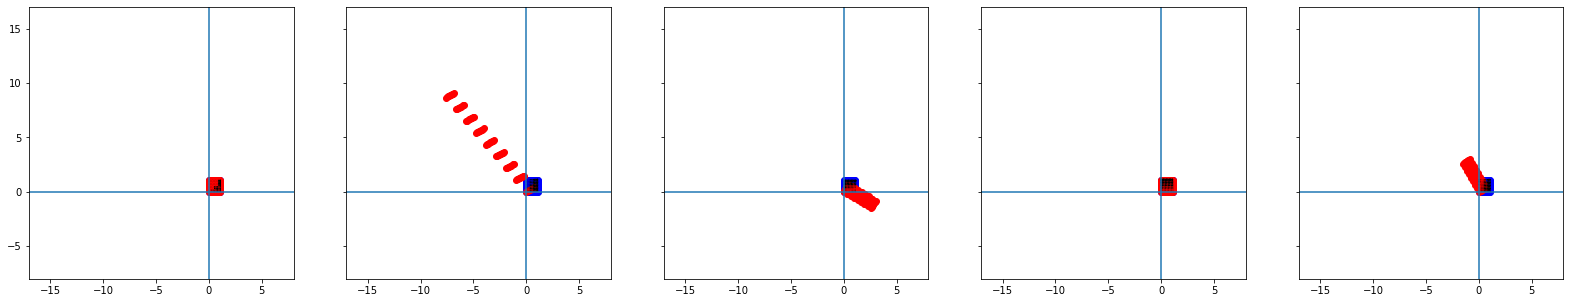

=== 0.9 ===
       [[1. 0.]                     [[-22.66   0.63]             [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 23.66   0.37]]             [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


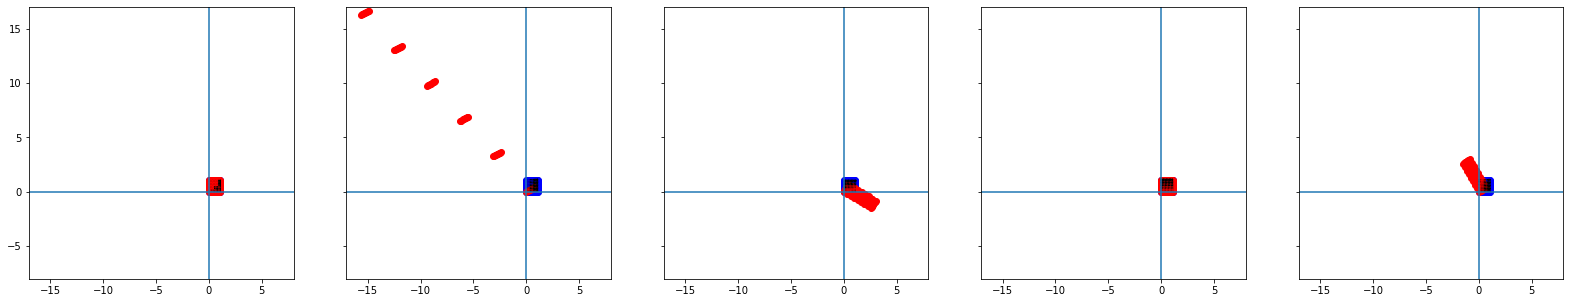

=== 0.95 ===
       [[1. 0.]                     [[-46.32   0.63]             [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 47.32   0.37]]             [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


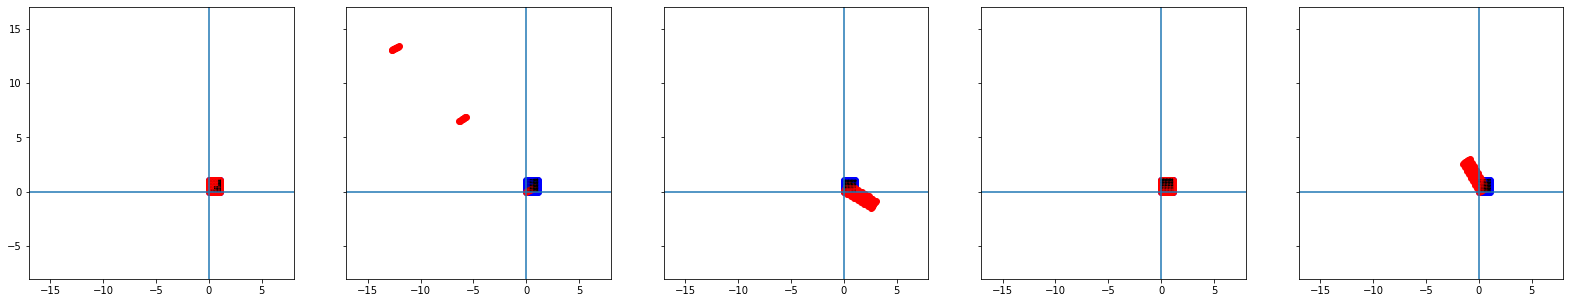

=== 0.99 ===
       [[1. 0.]                     [[-235.6     0.63]           [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 236.6     0.37]]           [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


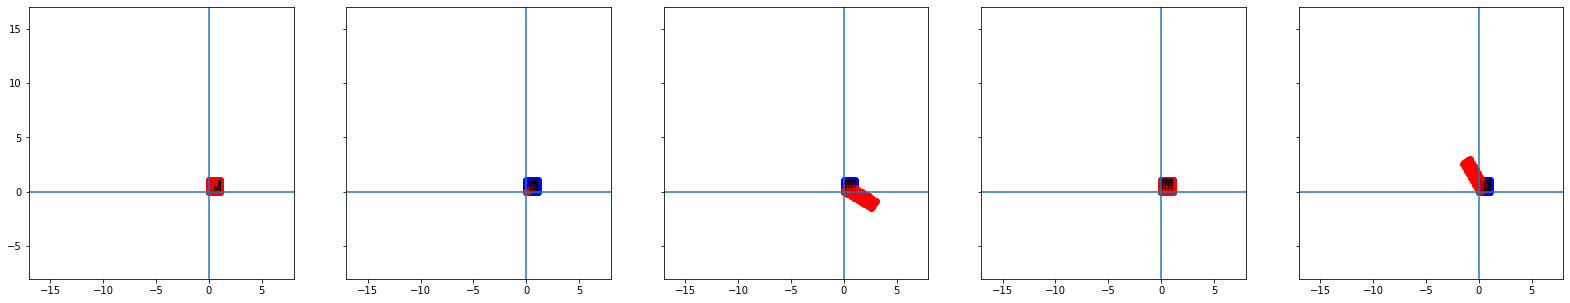

In [325]:
xlims, ylims = (-17, 8), (-8, 17)

for gamma in [.1, .3, .5, .7, .9, .95, .99]:
    print(f"=== {gamma} ===")
    weights_list_prime = [back_matrix(W, p, gamma, smart_gamma_func=smart_gamma_max_before_sign_flip) for W in weights_list]
    print_weights_list(weights_list_prime)
    plot_vector_field_batch(weights_list_prime, lims = np.array([0, 1.1]), xlims=xlims, ylims=ylims)
    plt.show()


point = [1. 1.]
['rot0', 'rot60', 'rot120', 'rot180', 'rot240']
       [[1. 0.]                     [[ 0.5  -0.87]               [[-0.5  -0.87]               [[-1. -0.]                   [[-0.5   0.87]               
        [0. 1.]]                     [ 0.87  0.5 ]]               [ 0.87 -0.5 ]]               [ 0. -1.]]                   [-0.87 -0.5 ]]              


/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:437: RuntimeWarning: divide by zero encountered in true_divide
  peaks_for_one_weight = - sum_at_neg_weight_entries / sum_at_pos_weight_entries - 1


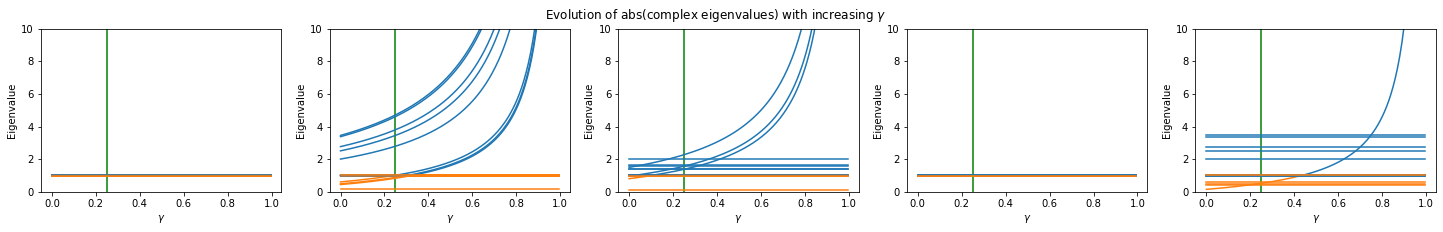

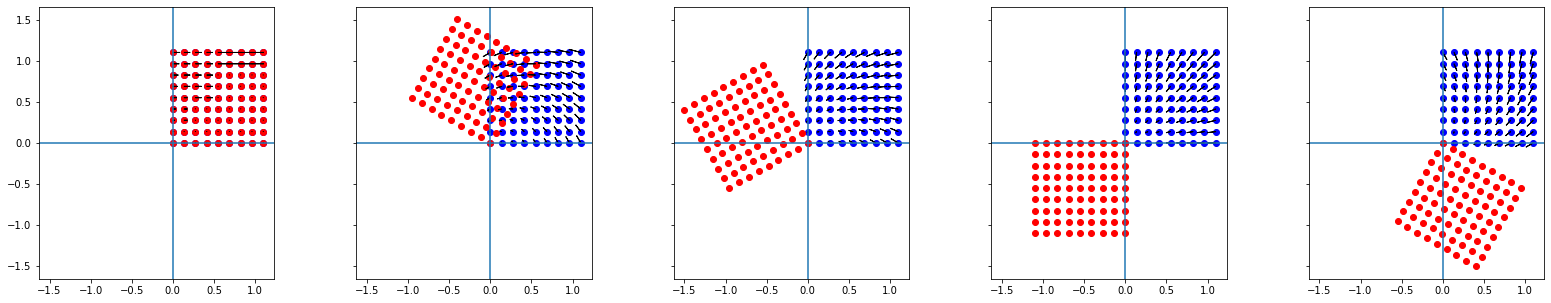

In [333]:
degs = np.linspace(0, 240, 5)
weights_list = [rotation1(deg) for deg in degs]
weights_lbls = [f"rot{round(deg)}" for deg in degs]

p = np.ones(2)
rng = RandomState(2)

points_list = [p]
if more_datapoints: points_list += [np.abs(rng.random(2)) for _ in range(9)]

print(weights_lbls)
print_weights_list(weights_list)
plot_evals_lineplot(calc_evals_batch(weights_list, points_list, mode='back', smart_gamma_func=smart_gamma_max_before_sign_flip), ylim=10)

print('point =', p)
plot_vector_field_batch(weights_list, lims = np.array([0, 1.1]))

=== 0.1 ===
       [[1. 0.]                     [[-1.63  0.63]               [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 2.63  0.37]]               [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:437: RuntimeWarning: divide by zero encountered in true_divide
  peaks_for_one_weight = - sum_at_neg_weight_entries / sum_at_pos_weight_entries - 1


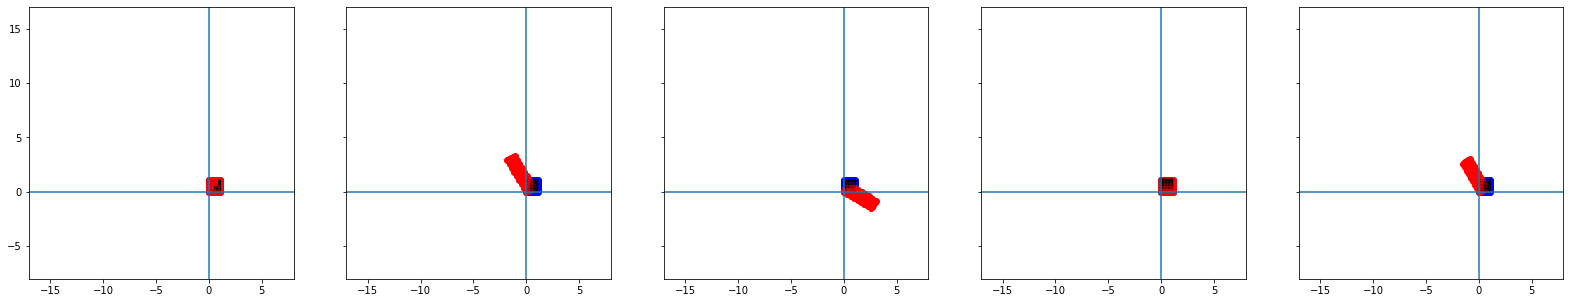

=== 0.3 ===
       [[1. 0.]                     [[-2.38  0.63]               [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 3.38  0.37]]               [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


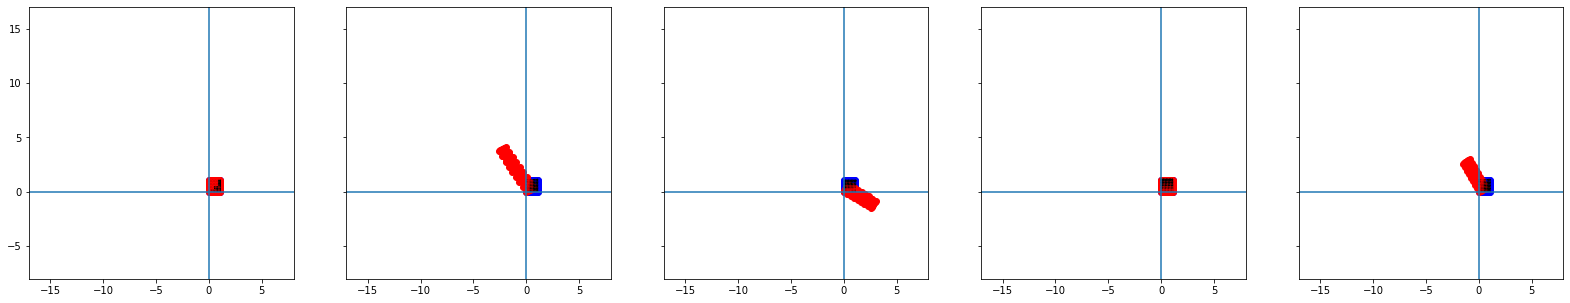

=== 0.5 ===
       [[1. 0.]                     [[-3.73  0.63]               [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 4.73  0.37]]               [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


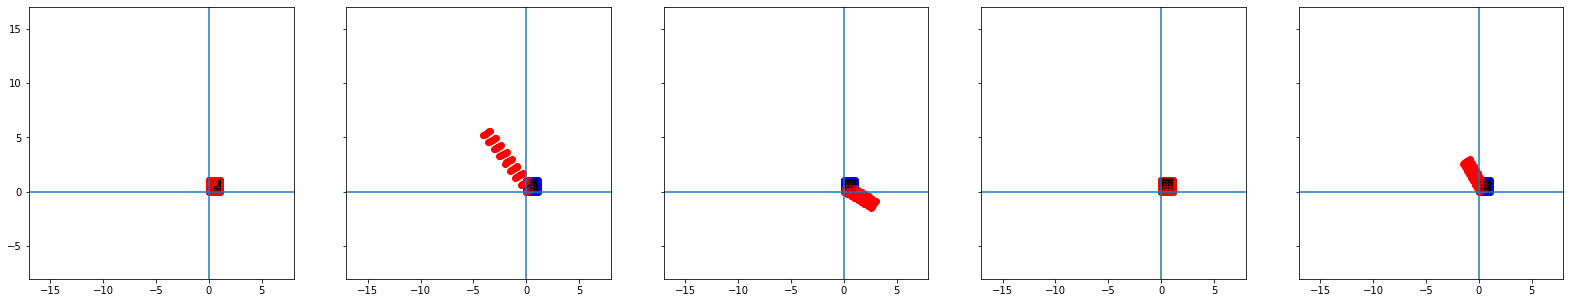

=== 0.7 ===
       [[1. 0.]                     [[-6.89  0.63]               [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 7.89  0.37]]               [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


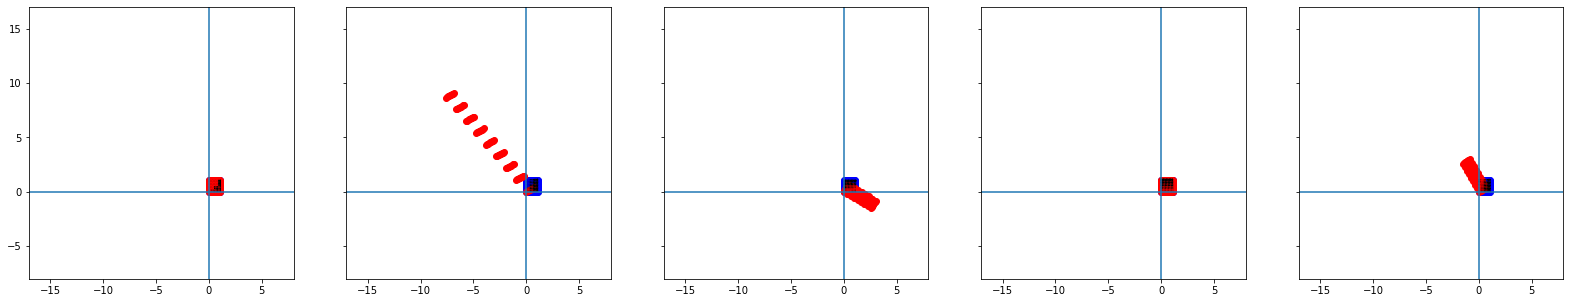

=== 0.9 ===
       [[1. 0.]                     [[-22.66   0.63]             [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 23.66   0.37]]             [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


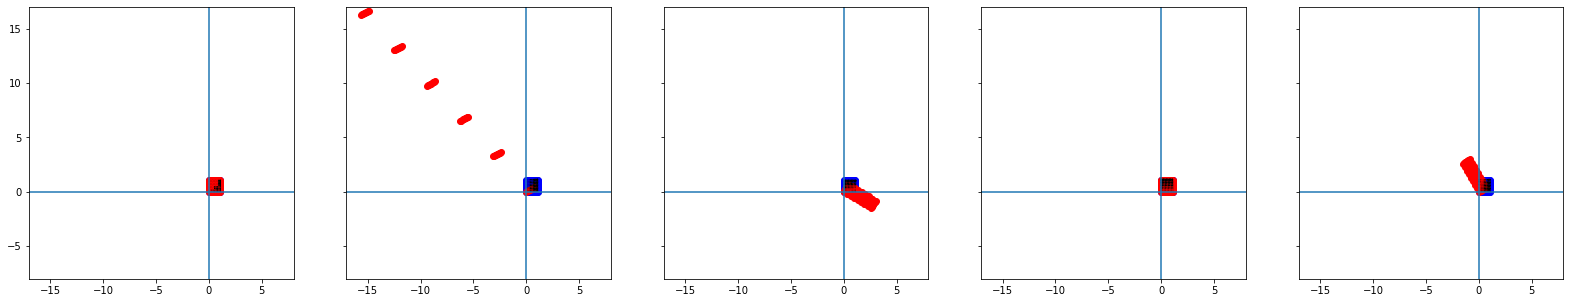

=== 0.95 ===
       [[1. 0.]                     [[-46.32   0.63]             [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 47.32   0.37]]             [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


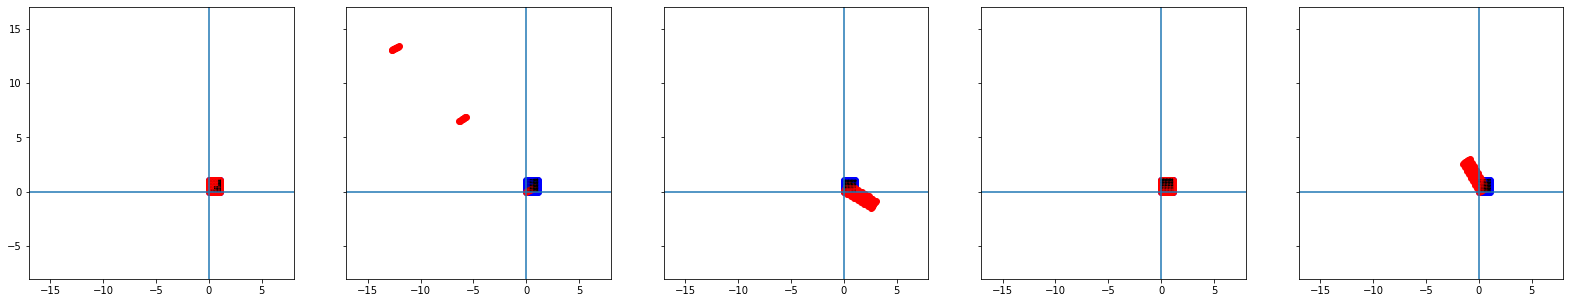

=== 0.99 ===
       [[1. 0.]                     [[-235.6     0.63]           [[ 0.37  2.37]               [[ 1. -0.]                   [[-1.37  0.63]               
        [0. 1.]]                     [ 236.6     0.37]]           [ 0.63 -1.37]]               [ 0.  1.]]                   [ 2.37  0.37]]              


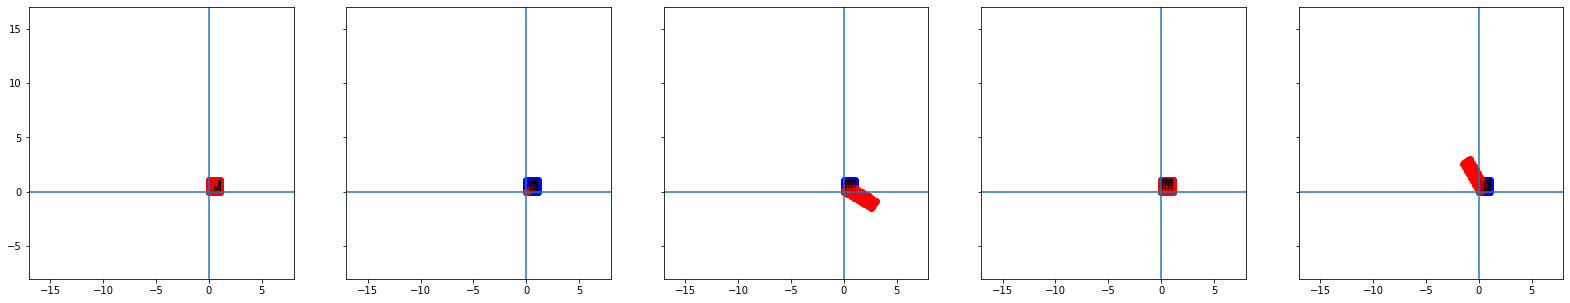

In [ ]:
xlims, ylims = (-17, 8), (-8, 17)

for gamma in [.1, .3, .5, .7, .9, .95, .99]:
    print(f"=== {gamma} ===")
    weights_list_prime = [back_matrix(W, p, gamma, smart_gamma_func=smart_gamma_max_before_sign_flip) for W in weights_list]
    print_weights_list(weights_list_prime)
    plot_vector_field_batch(weights_list_prime, lims = np.array([0, 1.1]), xlims=xlims, ylims=ylims)
    plt.show()


### weird rotation matrices

In [769]:
diff = 30 # rotational difference of second basis vectors projectors

degs = np.linspace(0, 340, 18)
weights_list = [rotation1(deg, deg + diff) for deg in degs]
weights_lbls = [f"rotB{round(deg)}" for deg in degs]

In [770]:
n = 50
rs = RandomState(1)
points_list = np.abs(rs.normal(0,1, size=(n,2)))
computed_evals2 = calc_evals_batch(np.array(weights_list)*-1, points_list, gammas, mode="back")

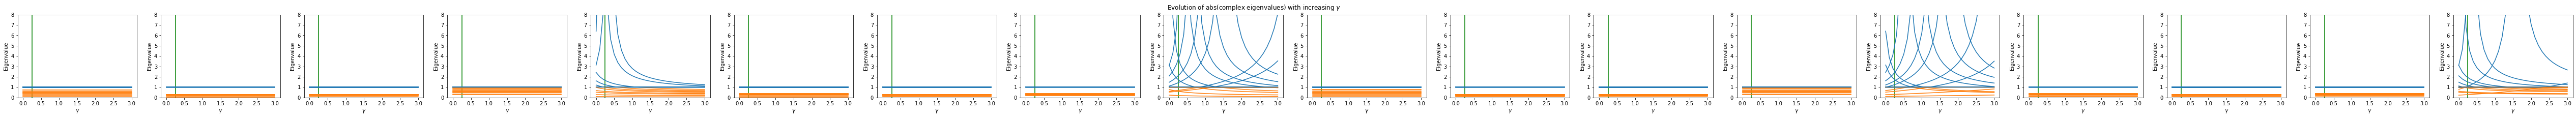

In [771]:
plot_evals_lineplot(computed_evals2[:, :10], gammas, one_plot_per='weight', mark_positive_slope=False, percentile_to_plot=None, ylim=8)

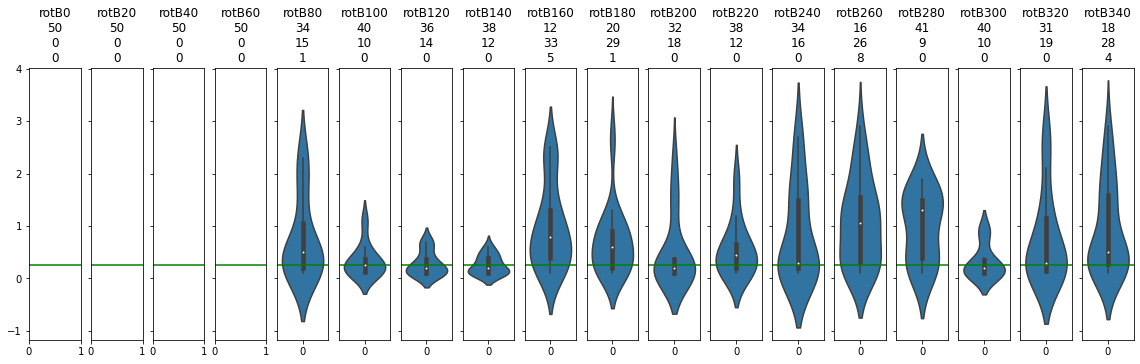

In [772]:
peaks = sign_flip_distribution_plot(weights_list, points_list, weights_lbls)

In [ ]:
plot_evals_lineplot(computed_evals[:, :10], gammas, one_plot_per='weight', mark_positive_slope=False, percentile_to_plot=None, ylim=8)

### Print out Backward matrices, Evals & Evecs for a few Gammas

In [597]:
plot = False

In [603]:
gamma_to_plot = 0

print_weights_list(degrees)
weights_list_prime = [back_matrix(rotation1(deg), points_list[p_i], gamma_to_plot) for deg in degrees]
print("gamma =", gamma_to_plot); print_weights_list_info(weights_list_prime)

if plot: plot_vector_field_batch(weights_list_prime, lims = np.array([0, 1.5]))

       -15                          -30                          -45                          -60                          -75                          -90                          
gamma = 0
Weights
       [[ 0.48 -0.07]               [[ 0.3  -0.17]               [[ 0.2  -0.33]               [[ 0.13 -0.76]               [[  0.06 -13.93]             [[ 0.  1.]                   
        [ 0.52  1.07]]               [ 0.7   1.17]]               [ 0.8   1.33]]               [ 0.87  1.76]]               [  0.94  14.93]]             [ 1. -0.]]                  
Evals
       [0.55 1.  ]                  [0.47 1.  ]                  [0.53 1.  ]                  [0.89 1.  ]                  [ 1.   13.99]                [ 1. -1.]                    
Evecs
       [[-0.71  0.14]               [[-0.71  0.23]               [[-0.71  0.38]               [[-0.71  0.66]               [[-1.    0.71]               [[ 0.71 -0.71]               
        [ 0.71 -0.99]]               [ 0.71 -0.97]]         

In [604]:
gamma_to_plot = 0.5

print_weights_list(degrees)
weights_list_prime = [back_matrix(rotation1(deg), points_list[p_i], gamma_to_plot) for deg in degrees]
print("gamma =", gamma_to_plot); print_weights_list_info(weights_list_prime)

if plot: plot_vector_field_batch(weights_list_prime, lims = np.array([0, 1.5]))

       -15                          -30                          -45                          -60                          -75                          -90                          
gamma = 0.5
Weights
       [[ 0.48 -0.05]               [[ 0.3  -0.11]               [[ 0.2 -0.2]                 [[ 0.13 -0.41]               [[ 0.06 -1.65]               [[ 0.  1.]                   
        [ 0.52  1.05]]               [ 0.7   1.11]]               [ 0.8  1.2]]                 [ 0.87  1.41]]               [ 0.94  2.65]]               [ 1. -0.]]                  
Evals
       [0.53 1.  ]                  [0.41 1.  ]                  [0.4 1. ]                    [0.53 1.  ]                  [1.   1.71]                  [ 1. -1.]                    
Evecs
       [[-0.71  0.09]               [[-0.71  0.15]               [[-0.71  0.24]               [[-0.71  0.42]               [[-0.87  0.71]               [[ 0.71 -0.71]               
        [ 0.71 -1.  ]]               [ 0.71 -0.99]]       

In [605]:
gamma_to_plot = 1

print_weights_list(degrees)
weights_list_prime = [back_matrix(rotation1(deg), points_list[p_i], gamma_to_plot) for deg in degrees]
print("gamma =", gamma_to_plot); print_weights_list_info(weights_list_prime)

if plot: plot_vector_field_batch(weights_list_prime, lims = np.array([0, 1.5]))

       -15                          -30                          -45                          -60                          -75                          -90                          
gamma = 1
Weights
       [[ 0.48 -0.03]               [[ 0.3  -0.08]               [[ 0.2  -0.14]               [[ 0.13 -0.28]               [[ 0.06 -0.87]               [[ 0.  1.]                   
        [ 0.52  1.03]]               [ 0.7   1.08]]               [ 0.8   1.14]]               [ 0.87  1.28]]               [ 0.94  1.87]]               [ 1. -0.]]                  
Evals
       [0.52 1.  ]                  [0.38 1.  ]                  [0.34 1.  ]                  [0.4 1. ]                    [0.94 1.  ]                  [ 1. -1.]                    
Evecs
       [[-0.71  0.07]               [[-0.71  0.11]               [[-0.71  0.18]               [[-0.71  0.3 ]               [[-0.71  0.68]               [[ 0.71 -0.71]               
        [ 0.71 -1.  ]]               [ 0.71 -0.99]]         

### Find interesting spot while scaling gamma up:

[0.   0.06 0.12 0.18 0.24 0.3 ]
Weights
       [[ 0.46  0.54]               [[ 0.46  0.54]               [[  0.46   0.54]             [[   0.46    0.54]           [[  0.46   0.54]             [[  0.46   0.54]             
        [ 6.22 -5.22]]               [ 9.05 -8.05]]               [ 16.61 -15.61]]             [ 101.39 -100.39]]           [-24.7   25.7 ]]             [-11.01  12.01]]            
Evals
       [ 1.   -5.76]                [ 1.   -8.59]                [  1.   -16.15]              [   1.   -100.94]            [ 1.   25.16]                [ 1.   11.47]                
Evecs
       [[ 0.71 -0.09]               [[ 0.71 -0.06]               [[ 0.71 -0.03]               [[ 0.71 -0.01]               [[-0.71 -0.02]               [[-0.71 -0.05]               
        [ 0.71  1.  ]]               [ 0.71  1.  ]]               [ 0.71  1.  ]]               [ 0.71  1.  ]]               [-0.71 -1.  ]]               [-0.71 -1.  ]]              


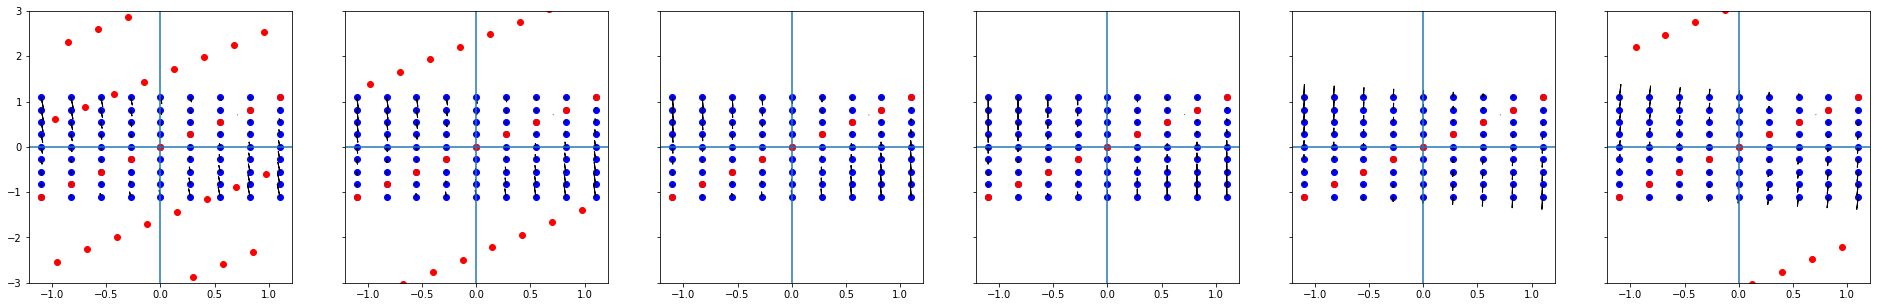

In [545]:
gammas = np.linspace(0,.3,6)
print(gammas)
weights_list = [back_matrix(rotation1(-50), None, gamma) for gamma in gammas]
print_weights_list_info(weights_list)

plot_vector_field_batch(weights_list, point_in_green=np.array([.71, .71]))

## Side investigation: What Eigenvectors does numpy return, when there are no two distinct eigenvector?
- Example: 2D Shear operation 
    - Eigenvalue 1 has algebraic multiplicity of 2, but geometric multiplicity of 1
    - Thus there is only one Eigen**vector**
- Result: 
    - Numpy returns a small bullshit vector as the second Eigenvector.
    - It is the first Eigenvector flippe, except for a tiny y component.
    - Technically the Diagonalization is impossible: If we still do it, the result of multiplying the decomposed parts is the Identity matrix.

[[1 1]
 [0 1]]

[1. 1.]
[[ 1.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  2.22044605e-16]]


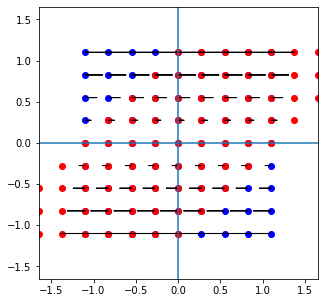

In [456]:
W = np.array([[1, 1], [0, 1]])

print(W)
print()

evals, evecs = LA.eig(W)
print(evals)
print(evecs)
plot_vector_field(W, figsize=(5,5))

In [457]:
evecs

array([[ 1.00000000e+00, -1.00000000e+00],
       [ 0.00000000e+00,  2.22044605e-16]])

In [458]:
LA.inv(evecs)

array([[1.00000000e+00, 4.50359963e+15],
       [0.00000000e+00, 4.50359963e+15]])

In [459]:
np.diag(evals)

array([[1., 0.],
       [0., 1.]])

In [460]:
evecs

array([[ 1.00000000e+00, -1.00000000e+00],
       [ 0.00000000e+00,  2.22044605e-16]])

In [461]:
evecs @ np.diag(evals) @ LA.inv(evecs)

array([[1., 0.],
       [0., 1.]])

In [106]:
evecs

array([[0.70710678+0.j        , 0.70710678-0.j        ],
       [0.        +0.70710678j, 0.        -0.70710678j]])

In [115]:
for i in range(2):
    print(W @ evecs[:, i] == evecs[:, i] * evals[i])
    print(W @ evecs[:, i], evecs[:, i] * evals[i])

[ True  True]
[1. 0.] [1. 0.]
[False  True]
[-1.00000000e+00  2.22044605e-16] [-1.00000000e+00  2.22044605e-16]
